# Test Maximum snow density implemented in CLASSIC snow model

**env: sc2_v0**

The maximum snow density s,max is estimated as a function of snow depth zs, after Tabler et al. (1990):
s,max=As-204.70zs1.0-e-zs0.673
Following Brown et al. (2006), the empirical constant As is assigned a value of 450.0 for cold snowpacks and 700.0 for snowpacks near the melting point:

   if (FI(I) > 0. .and. ZSNOW(I) > 0.0001) then
     if (TSNOW(I) < - 0.01) then
       RHOMAX(I) = 450.0 - (204.7 / ZSNOW(I)) * &
                   (1.0 - EXP( - ZSNOW(I) / 0.673))
     else
       RHOMAX(I) = 700.0 - (204.7 / ZSNOW(I)) * &
                   (1.0 - EXP( - ZSNOW(I) / 0.673))
     end if
   end if



In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xskillscore as xs
import calendar
import os

## Define parameterizations

In [2]:
def BR06_dry(sd):
    """
    Calculates the maximum snow density using the Brown et al. (2006) parameterization for dry snow.
    (https://doi.org/10.3137/ao.440302)

    Parameters:
    sd (float): Snow depth [m]

    Returns:
    rho_max (float): The maximum snow density [kg m$^{-3}$.
    """
    rho_max = 450.0 - (204.7 / sd) * (1.0 - np.exp( - sd / 0.673))
    return rho_max

def BR06_wet(sd):
    """
    Calculates the maximum snow density using the Brown et al. (2006) parameterization for wet snow.
    (https://doi.org/10.3137/ao.440302)

    Parameters:
    sd (float): Snow depth [m]

    Returns:
    rho_max (float): The maximum snow density [kg m$^{-3}$.
    """
    rho_max = 700.0 - (204.7 / sd) * (1.0 - np.exp( - sd / 0.673))
    return rho_max

def TB90(sd):
    """
    Calculates the maximum snow density using the Tabler et al. (1990) parameterization.
    (https://westernsnowconference.org/node/620)

    Parameters:
    sd (float): Snow depth [m]

    Returns:
    rho_max (float): The maximum snow density [kg m$^{-3}$.
    """
    rho_max = 522.0 - (204.7 / sd) * (1.0 - np.exp( - sd / 0.673))
    return rho_max

In [3]:
sd = pplt.arange(0.1, 5, 0.1)
sd

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

In [4]:
BR06_wet(sd)

array([417.35802071, 436.87108579, 454.58795764, 470.6946449 ,
       485.35660953, 498.72113097, 510.9193905 , 522.06830966,
       532.2721722 , 541.62405588, 550.20709666, 558.09560549,
       565.35605535, 572.04795382, 578.22461499, 583.93384249,
       589.21853425, 594.11721811, 598.66452652, 602.89161737,
       606.8265474 , 610.49460345, 613.91859675, 617.11912434,
       620.11480142, 622.9224681 , 625.55737332, 628.0333387 ,
       630.36290447, 632.55745962, 634.627358  , 636.58202195,
       638.43003486, 640.17922395, 641.83673422, 643.40909476,
       644.90227804, 646.32175308, 647.67253316, 648.95921863,
       650.18603534, 651.35686925, 652.47529745, 653.54461621,
       654.56786618, 655.5478551 , 656.48717835, 657.38823748,
       658.25325693, 659.08429917])

## Plot

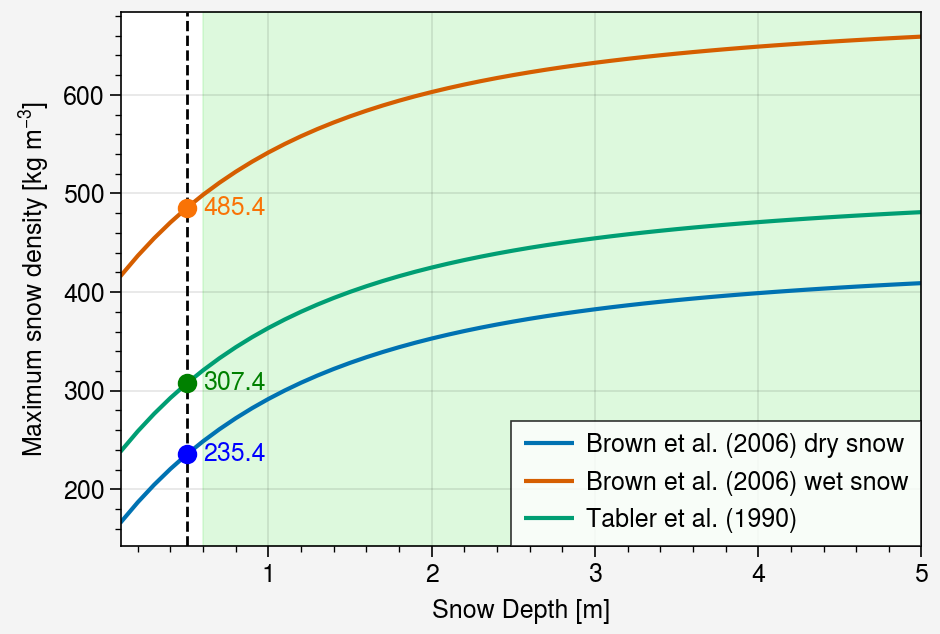

In [5]:
fig, axs = pplt.subplots(refwidth=4, refaspect=1.5)

ax = axs[0]

ax.plot(sd, BR06_dry(sd), label='Brown et al. (2006) dry snow')
ax.plot(sd, BR06_wet(sd), label='Brown et al. (2006) wet snow')
ax.plot(sd, TB90(sd), label='Tabler et al. (1990)')

# Add the shaded rectangle
ax.axvspan(0.6, sd[-1], color='lightgreen', alpha=0.3)

# Add the vertical line at snow depth of 0.5
ax.axvline(0.5, color='black', linestyle='--', lw=1)

# Calculate and annotate the crossing values
dry_crossing = BR06_dry(0.5)
wet_crossing = BR06_wet(0.5)
tb90_crossing = TB90(0.5)

# Plot the intersection points
ax.plot(0.5, dry_crossing, 'o', color='blue')
ax.plot(0.5, wet_crossing, 'o', color='orange')
ax.plot(0.5, tb90_crossing, 'o', color='green')

# Annotate the crossing values
ax.text(0.6, dry_crossing, f'{dry_crossing:.1f}', verticalalignment='center', color='blue')
ax.text(0.6, wet_crossing, f'{wet_crossing:.1f}', verticalalignment='center', color='orange')
ax.text(0.6, tb90_crossing, f'{tb90_crossing:.1f}', verticalalignment='center', color='green')

ax.format(
    xlabel='Snow Depth [m]',
    ylabel='Maximum snow density [kg m$^{-3}$]',
)

ax.legend(ncols=1)
# fig.save('img/rho_max_vs_sd.jpg')

In [6]:
def rho_m(sd):
    rho_max = 430.0 - (204.7 / sd) * (1.0 - np.exp( - sd / 0.673))
    return rho_max

def rho_max_wind(sd, u):
    rho_max = 430.0 - (204.7 / sd) * (1.0 - np.exp( - sd / 0.673)) * np.exp(-u/2.5)
    return rho_max

def rho_max_gauss(sd, u):
    rho_max = rho_m(sd) + (rho_max_wind(sd, u) - rho_m(sd)) * np.exp(- (sd - 0.8)**2 / (2*1**2))
    return rho_max

def rho_max_gauss_2(sd, u):
    rho_max = 430.0 - (204.7 / sd) * (1.0 - np.exp( - sd / 0.673)) + \
        (204.7 / sd) * (1.0 - np.exp( - sd / 0.673)) * (1 - np.exp(-u/2.5)) * np.exp(- (sd - 0.8)**2 / (2*1**2))
    return rho_max

def rho_max_gauss_3(sd, u):
    rho_max = 430.0 - (204.7 / sd) * (1.0 - np.exp( - sd / 0.673)) * \
        (1 - (1 - np.exp(-u/2.5)) * np.exp(- (sd - 0.8)**2 / (2*1**2)) ) 
    return rho_max

In [7]:
def rho_m_TVC(sd):
    rho_max = 430.0 - (204.7 / sd) * (1.0 - np.exp( - sd / 0.673))
    return rho_max

def rho_max_wind_TVC(sd, u):
    rho_max = 430.0 - (204.7 / sd) * (1.0 - np.exp( - sd / 0.673)) * np.exp(-u/3.5)
    return rho_max

def rho_max_gauss_TVC(sd, u):
    rho_max = rho_m(sd) + (rho_max_wind_TVC(sd, u) - rho_m(sd)) * np.exp(- (sd - 0.8)**2 / (2*1**2))
    return rho_max

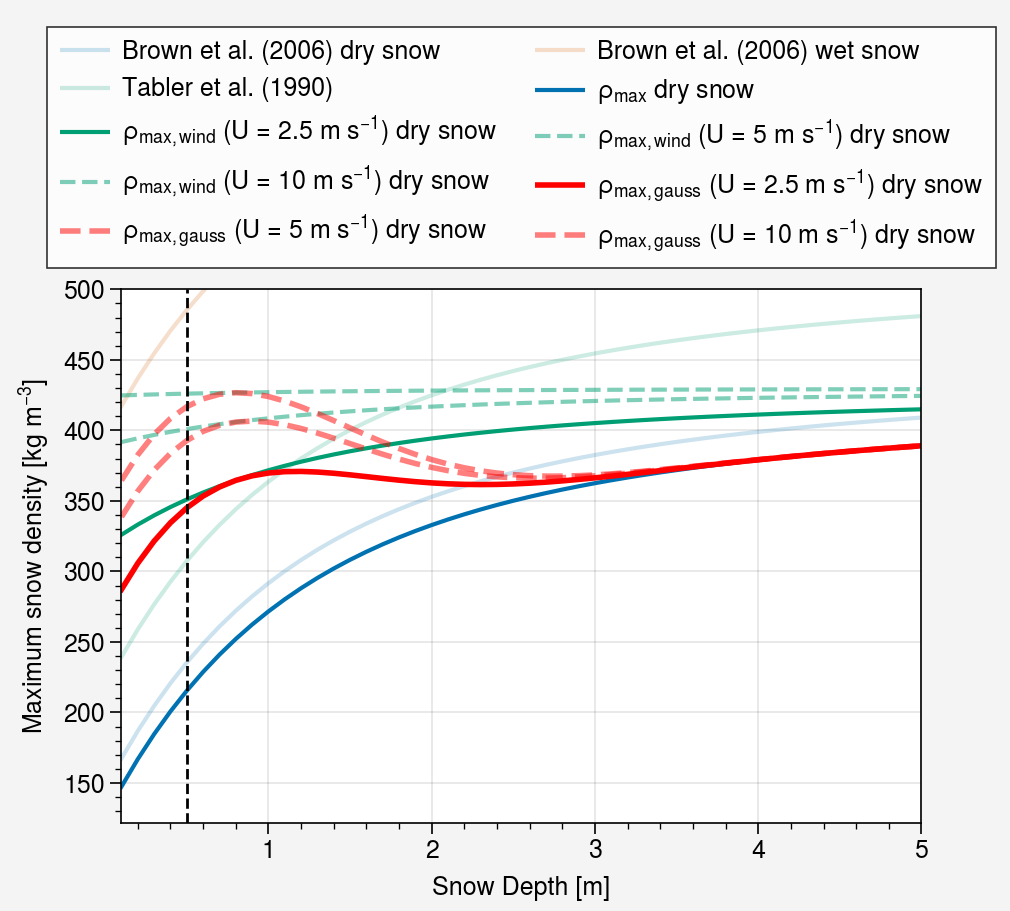

In [8]:
fig, axs = pplt.subplots(refwidth=4, refaspect=1.5)

ax = axs[0]

sd = pplt.arange(0.1, 5, 0.1)

ax.plot(sd, BR06_dry(sd), label='Brown et al. (2006) dry snow', alpha=0.2)
ax.plot(sd, BR06_wet(sd), label='Brown et al. (2006) wet snow', alpha=0.2)
ax.plot(sd, TB90(sd), label='Tabler et al. (1990)', alpha=0.2)


ax.plot(sd, rho_m(sd), label='$\\rho_{max}$ dry snow', c='C0')
ax.plot(sd, rho_max_wind(sd, 2.5), label='$\\rho_{max,wind}$ (U = 2.5 m s$^{-1}$) dry snow', c='C2')
ax.plot(sd, rho_max_wind(sd, 5), label='$\\rho_{max,wind}$ (U = 5 m s$^{-1}$) dry snow', c='C2', ls='--', alpha=0.5)
ax.plot(sd, rho_max_wind(sd, 10), label='$\\rho_{max,wind}$ (U = 10 m s$^{-1}$) dry snow', c='C2', ls='--', alpha=0.5)

ax.plot(sd, rho_max_gauss(sd, 2.5), label='$\\rho_{max,gauss}$ (U = 2.5 m s$^{-1}$) dry snow', c='red', lw=2)
ax.plot(sd, rho_max_gauss(sd, 5), label='$\\rho_{max,gauss}$ (U = 5 m s$^{-1}$) dry snow', c='red', ls='--', alpha=0.5, lw=2)
ax.plot(sd, rho_max_gauss(sd, 10), label='$\\rho_{max,gauss}$ (U = 10 m s$^{-1}$) dry snow', c='red', ls='--', alpha=0.5, lw=2)

ax.axvline(0.5, color='black', linestyle='--', lw=1)



ax.format(
    xlabel='Snow Depth [m]',
    ylabel='Maximum snow density [kg m$^{-3}$]',
    ymax=500, 
)

ax.legend(ncols=2, loc='t')
# fig.save('img/rho_max_vs_sd_gauss_mtr.jpg')

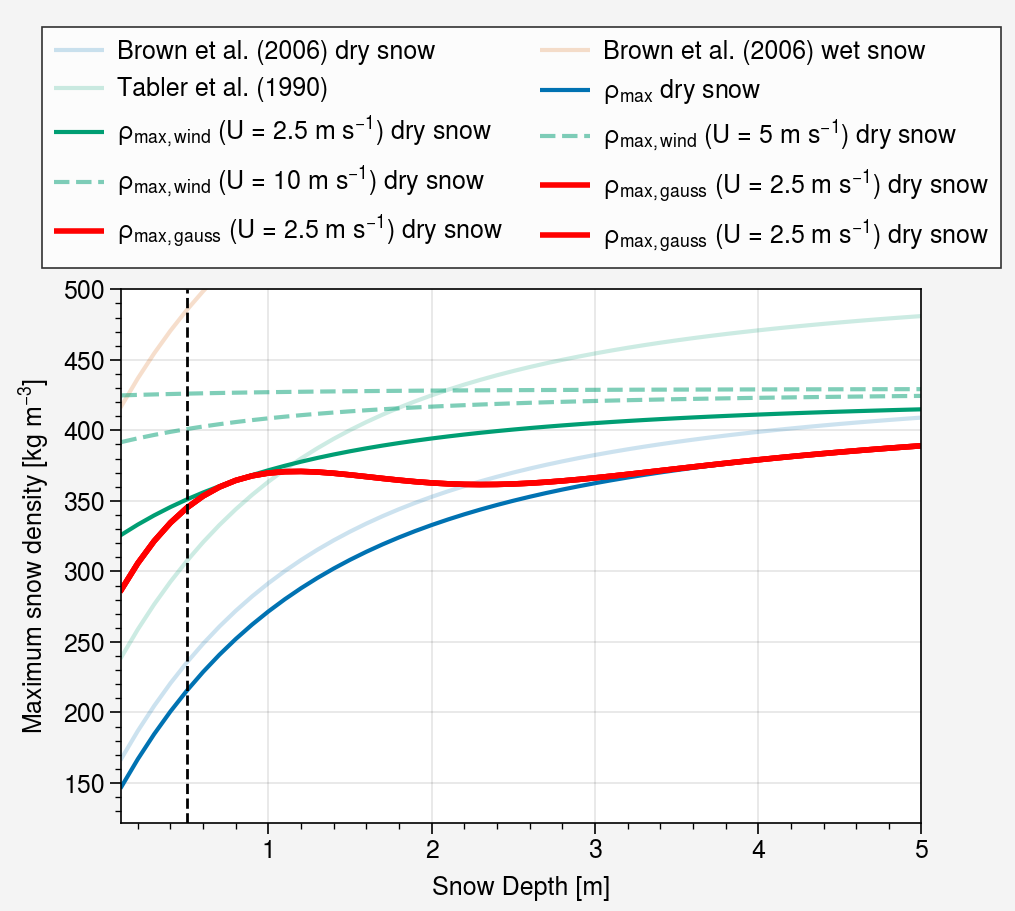

In [9]:
fig, axs = pplt.subplots(refwidth=4, refaspect=1.5)

ax = axs[0]

sd = pplt.arange(0.1, 5, 0.1)

ax.plot(sd, BR06_dry(sd), label='Brown et al. (2006) dry snow', alpha=0.2)
ax.plot(sd, BR06_wet(sd), label='Brown et al. (2006) wet snow', alpha=0.2)
ax.plot(sd, TB90(sd), label='Tabler et al. (1990)', alpha=0.2)


ax.plot(sd, rho_m(sd), label='$\\rho_{max}$ dry snow', c='C0')
ax.plot(sd, rho_max_wind(sd, 2.5), label='$\\rho_{max,wind}$ (U = 2.5 m s$^{-1}$) dry snow', c='C2')
ax.plot(sd, rho_max_wind(sd, 5), label='$\\rho_{max,wind}$ (U = 5 m s$^{-1}$) dry snow', c='C2', ls='--', alpha=0.5)
ax.plot(sd, rho_max_wind(sd, 10), label='$\\rho_{max,wind}$ (U = 10 m s$^{-1}$) dry snow', c='C2', ls='--', alpha=0.5)

# Check the factorized versions of the equation
ax.plot(sd, rho_max_gauss(sd, 2.5), label='$\\rho_{max,gauss}$ (U = 2.5 m s$^{-1}$) dry snow', c='red', lw=2)
ax.plot(sd, rho_max_gauss_2(sd, 2.5), label='$\\rho_{max,gauss}$ (U = 2.5 m s$^{-1}$) dry snow', c='red', lw=2)
ax.plot(sd, rho_max_gauss_3(sd, 2.5), label='$\\rho_{max,gauss}$ (U = 2.5 m s$^{-1}$) dry snow', c='red', lw=2)

ax.axvline(0.5, color='black', linestyle='--', lw=1)



ax.format(
    xlabel='Snow Depth [m]',
    ylabel='Maximum snow density [kg m$^{-3}$]',
    ymax=500, 
)

ax.legend(ncols=2, loc='t')
# fig.save('img/rho_max_vs_sd_gauss_mtr.jpg')

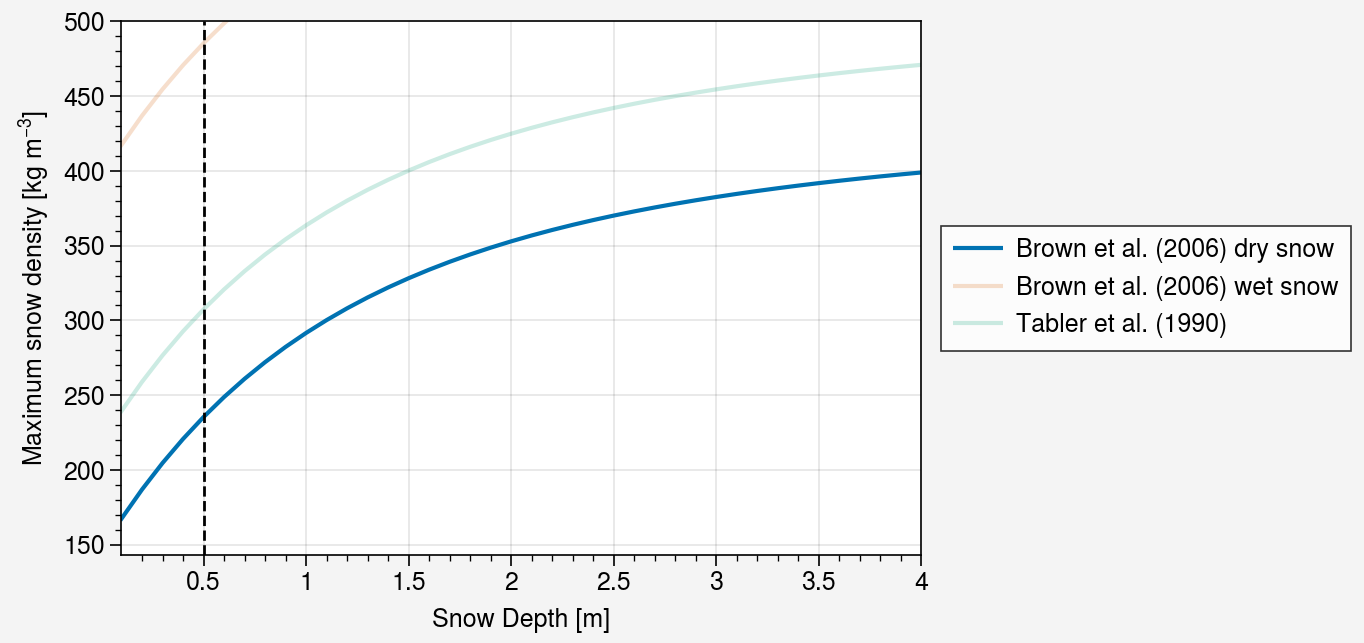

In [10]:
fig, axs = pplt.subplots(refwidth=4, refaspect=1.5)

ax = axs[0]

sd = pplt.arange(0.1, 4, 0.1)

ax.plot(sd, BR06_dry(sd), label='Brown et al. (2006) dry snow', alpha=1)
ax.plot(sd, BR06_wet(sd), label='Brown et al. (2006) wet snow', alpha=0.2)
ax.plot(sd, TB90(sd), label='Tabler et al. (1990)', alpha=0.2)


# ax.plot(sd, rho_m(sd), label='$\\rho_{max}$ dry snow', c='C0')
# ax.plot(sd, rho_max_wind(sd, 2.5), label='$\\rho_{max,wind}$ (U = 2.5 m s$^{-1}$) dry snow', c='C2')
# ax.plot(sd, rho_max_wind(sd, 5), label='$\\rho_{max,wind}$ (U = 5 m s$^{-1}$) dry snow', c='C2', ls='--', alpha=0.5)
# ax.plot(sd, rho_max_wind(sd, 10), label='$\\rho_{max,wind}$ (U = 10 m s$^{-1}$) dry snow', c='C2', ls='--', alpha=0.5)

# ax.plot(sd, rho_max_gauss(sd, 2.5), label='$\\rho_{max,gauss}$ (U = 2.5 m s$^{-1}$) dry snow', c='red', lw=2)
# ax.plot(sd, rho_max_gauss(sd, 5), label='$\\rho_{max,gauss}$ (U = 5 m s$^{-1}$) dry snow', c='red', ls='--', alpha=0.5, lw=2)
# ax.plot(sd, rho_max_gauss(sd, 10), label='$\\rho_{max,gauss}$ (U = 10 m s$^{-1}$) dry snow', c='red', ls='--', alpha=0.5, lw=2)

ax.axvline(0.5, color='black', linestyle='--', lw=1)



ax.format(
    xlabel='Snow Depth [m]',
    ylabel='Maximum snow density [kg m$^{-3}$]',
    ymax=500, 
)

ax.legend(ncols=1, loc='r')
# fig.save('img/rho_max_vs_sd_gauss_mtr_0.png')

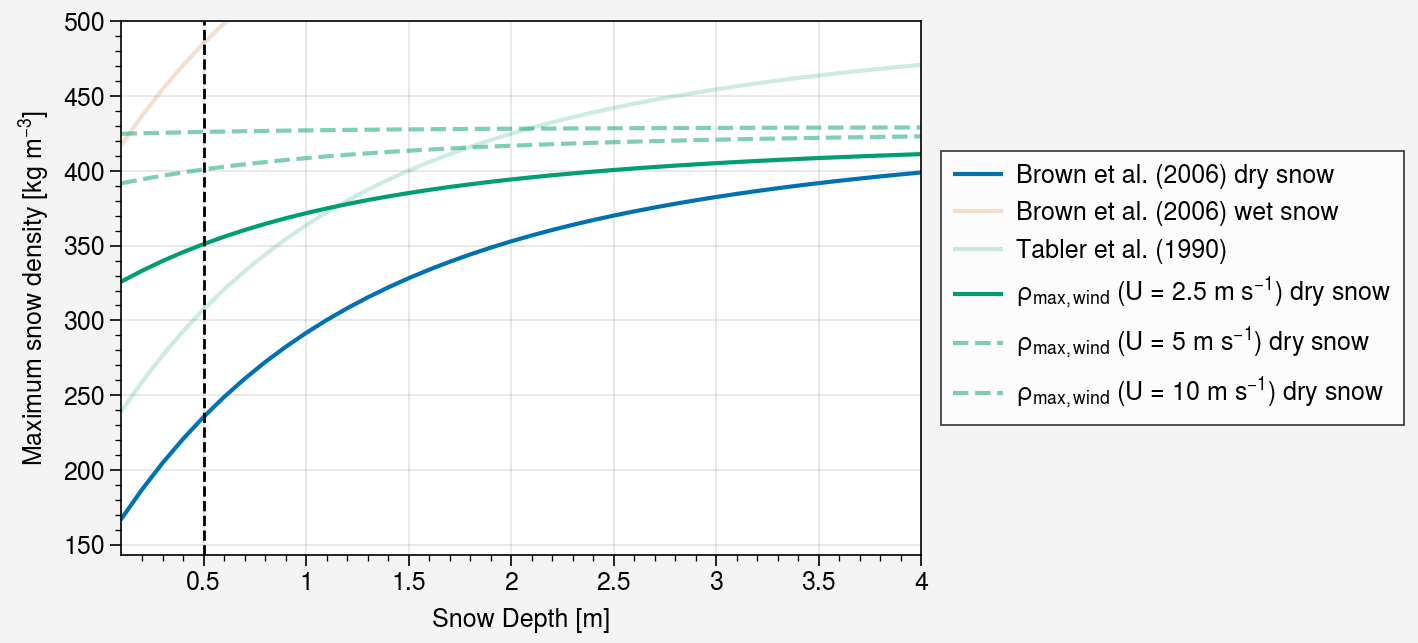

In [11]:
fig, axs = pplt.subplots(refwidth=4, refaspect=1.5)

ax = axs[0]

sd = pplt.arange(0.1, 4, 0.1)

ax.plot(sd, BR06_dry(sd), label='Brown et al. (2006) dry snow', alpha=1)
ax.plot(sd, BR06_wet(sd), label='Brown et al. (2006) wet snow', alpha=0.2)
ax.plot(sd, TB90(sd), label='Tabler et al. (1990)', alpha=0.2)


# ax.plot(sd, rho_m(sd), label='$\\rho_{max}$ dry snow', c='C0')
ax.plot(sd, rho_max_wind(sd, 2.5), label='$\\rho_{max,wind}$ (U = 2.5 m s$^{-1}$) dry snow', c='C2')
ax.plot(sd, rho_max_wind(sd, 5), label='$\\rho_{max,wind}$ (U = 5 m s$^{-1}$) dry snow', c='C2', ls='--', alpha=0.5)
ax.plot(sd, rho_max_wind(sd, 10), label='$\\rho_{max,wind}$ (U = 10 m s$^{-1}$) dry snow', c='C2', ls='--', alpha=0.5)

# ax.plot(sd, rho_max_gauss(sd, 2.5), label='$\\rho_{max,gauss}$ (U = 2.5 m s$^{-1}$) dry snow', c='red', lw=2)
# ax.plot(sd, rho_max_gauss(sd, 5), label='$\\rho_{max,gauss}$ (U = 5 m s$^{-1}$) dry snow', c='red', ls='--', alpha=0.5, lw=2)
# ax.plot(sd, rho_max_gauss(sd, 10), label='$\\rho_{max,gauss}$ (U = 10 m s$^{-1}$) dry snow', c='red', ls='--', alpha=0.5, lw=2)

ax.axvline(0.5, color='black', linestyle='--', lw=1)



ax.format(
    xlabel='Snow Depth [m]',
    ylabel='Maximum snow density [kg m$^{-3}$]',
    ymax=500, 
)

ax.legend(ncols=1, loc='r')
# fig.save('img/rho_max_vs_sd_gauss_mtr_1.png')

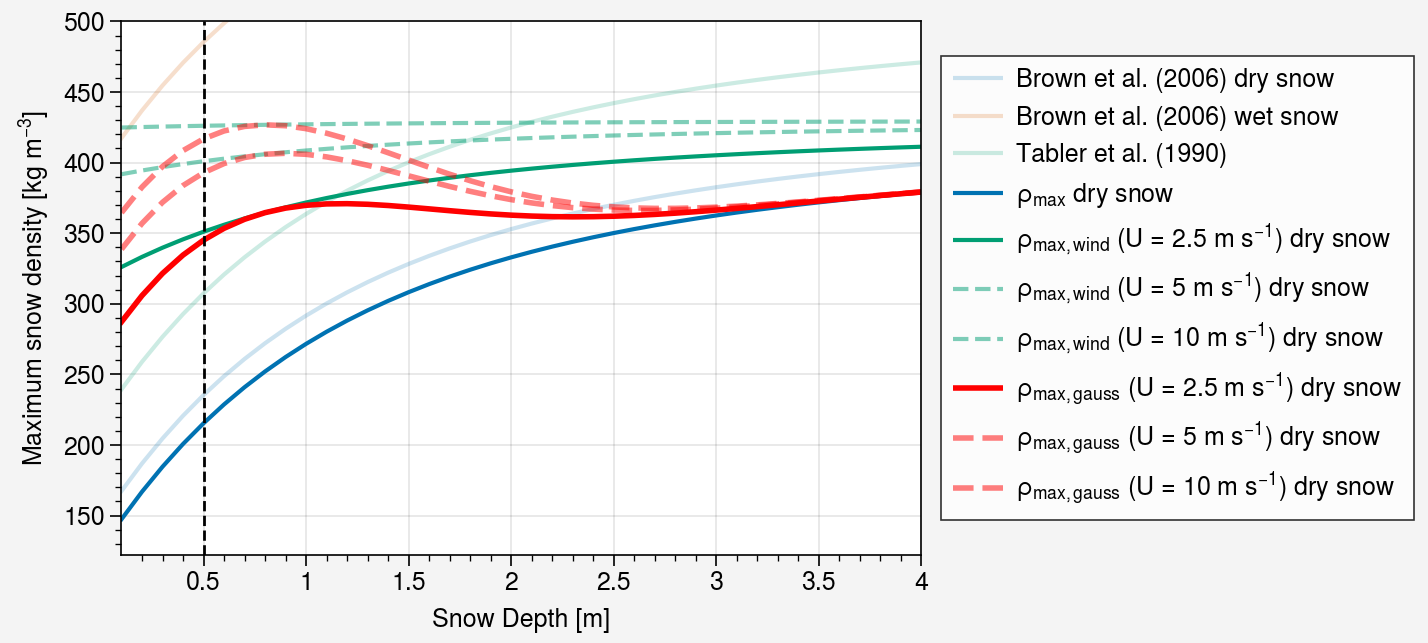

In [12]:
fig, axs = pplt.subplots(refwidth=4, refaspect=1.5)

ax = axs[0]

sd = pplt.arange(0.1, 4, 0.1)

ax.plot(sd, BR06_dry(sd), label='Brown et al. (2006) dry snow', alpha=0.2)
ax.plot(sd, BR06_wet(sd), label='Brown et al. (2006) wet snow', alpha=0.2)
ax.plot(sd, TB90(sd), label='Tabler et al. (1990)', alpha=0.2)


ax.plot(sd, rho_m(sd), label='$\\rho_{max}$ dry snow', c='C0')
ax.plot(sd, rho_max_wind(sd, 2.5), label='$\\rho_{max,wind}$ (U = 2.5 m s$^{-1}$) dry snow', c='C2')
ax.plot(sd, rho_max_wind(sd, 5), label='$\\rho_{max,wind}$ (U = 5 m s$^{-1}$) dry snow', c='C2', ls='--', alpha=0.5)
ax.plot(sd, rho_max_wind(sd, 10), label='$\\rho_{max,wind}$ (U = 10 m s$^{-1}$) dry snow', c='C2', ls='--', alpha=0.5)

ax.plot(sd, rho_max_gauss(sd, 2.5), label='$\\rho_{max,gauss}$ (U = 2.5 m s$^{-1}$) dry snow', c='red', lw=2)
ax.plot(sd, rho_max_gauss(sd, 5), label='$\\rho_{max,gauss}$ (U = 5 m s$^{-1}$) dry snow', c='red', ls='--', alpha=0.5, lw=2)
ax.plot(sd, rho_max_gauss(sd, 10), label='$\\rho_{max,gauss}$ (U = 10 m s$^{-1}$) dry snow', c='red', ls='--', alpha=0.5, lw=2)

ax.axvline(0.5, color='black', linestyle='--', lw=1)



ax.format(
    xlabel='Snow Depth [m]',
    ylabel='Maximum snow density [kg m$^{-3}$]',
    ymax=500, 
)

ax.legend(ncols=1, loc='r')
# fig.save('img/rho_max_vs_sd_gauss_mtr_3.png')

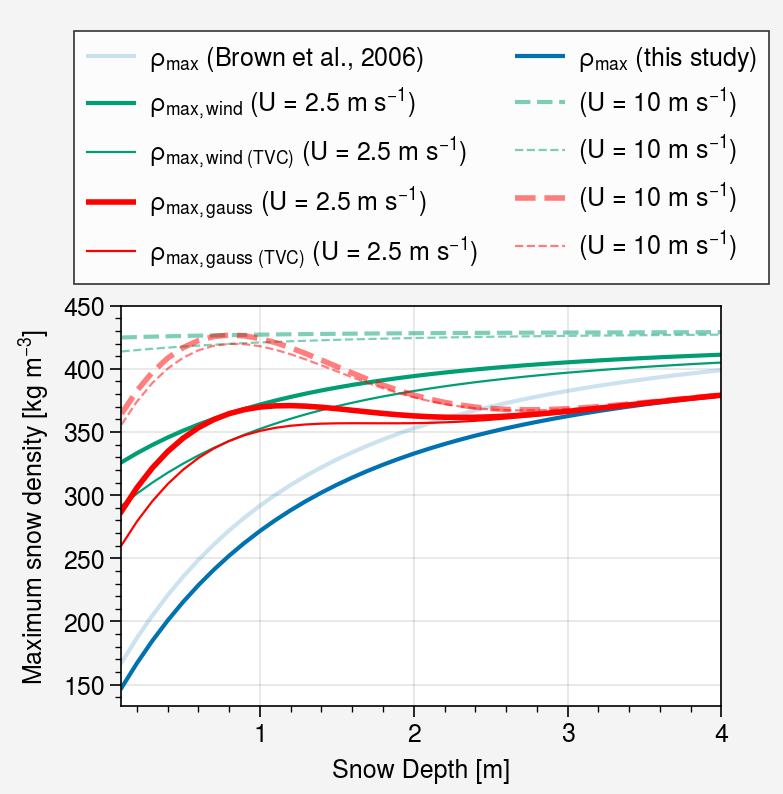

In [13]:
# fig, axs = pplt.subplots(refwidth=4, refaspect=1.5)
fig, axs = pplt.subplots(refwidth=3, refaspect=1.5)

ax = axs[0]

sd = pplt.arange(0.1, 4, 0.1)

lw_TVC = 0.8

ax.plot(sd, BR06_dry(sd), label='$\\rho_{max}$ (Brown et al., 2006)', alpha=0.2)

ax.plot(sd, rho_m(sd), label='$\\rho_{max}$ (this study)', c='C0')
ax.plot(sd, rho_max_wind(sd, 2.5), label='$\\rho_{max,wind}$ (U = 2.5 m s$^{-1}$)', c='C2')
# ax.plot(sd, rho_max_wind(sd, 5), label='$\\rho_{max,wind}$ (U = 5 m s$^{-1}$)', c='C2', ls='--', alpha=0.5)
ax.plot(sd, rho_max_wind(sd, 10), label='(U = 10 m s$^{-1}$)', c='C2', ls='--', alpha=0.5)

ax.plot(sd, rho_max_wind_TVC(sd, 2.5), label='$\\rho_{max,wind~(TVC)}$ (U = 2.5 m s$^{-1}$)', c='C2', lw=lw_TVC)
# ax.plot(sd, rho_max_wind_TVC(sd, 5), label='$\\rho_{max,wind~(TVC)}$ (U = 5 m s$^{-1}$)', c='C2', ls='--', alpha=0.5, lw=lw_TVC)
ax.plot(sd, rho_max_wind_TVC(sd, 10), label='(U = 10 m s$^{-1}$)', c='C2', ls='--', alpha=0.5, lw=lw_TVC)

ax.plot(sd, rho_max_gauss(sd, 2.5), label='$\\rho_{max,gauss}$ (U = 2.5 m s$^{-1}$)', c='red', lw=2)
# ax.plot(sd, rho_max_gauss(sd, 5), label='$\\rho_{max,gauss}$ (U = 5 m s$^{-1}$)', c='red', ls='--', alpha=0.5, lw=2)
ax.plot(sd, rho_max_gauss(sd, 10), label='(U = 10 m s$^{-1}$)', c='red', ls='--', alpha=0.5, lw=2)

ax.plot(sd, rho_max_gauss_TVC(sd, 2.5), label='$\\rho_{max,gauss~(TVC)}$ (U = 2.5 m s$^{-1}$)', c='red', lw=lw_TVC)
# ax.plot(sd, rho_max_gauss_TVC(sd, 5), label='$\\rho_{max,gauss~(TVC)}$ (U = 5 m s$^{-1}$)', c='red', ls='--', alpha=0.5, lw=lw_TVC)
ax.plot(sd, rho_max_gauss_TVC(sd, 10), label='(U = 10 m s$^{-1}$)', c='red', ls='--', alpha=0.5, lw=lw_TVC)

# ax.axvline(0.5, color='black', linestyle='--', lw=1)


ax.format(
    xlabel='Snow Depth [m]',
    ylabel='Maximum snow density [kg m$^{-3}$]',
    ymax=450, 
)

ax.legend(ncols=2, loc='t')
# fig.save('img/rho_max_vs_sd_gauss_final_v0.jpg')
# fig.save('img/rho_max_vs_sd_gauss_final_v0.png')
# fig.save('img/rho_max_vs_sd_gauss_final_v0.pdf')

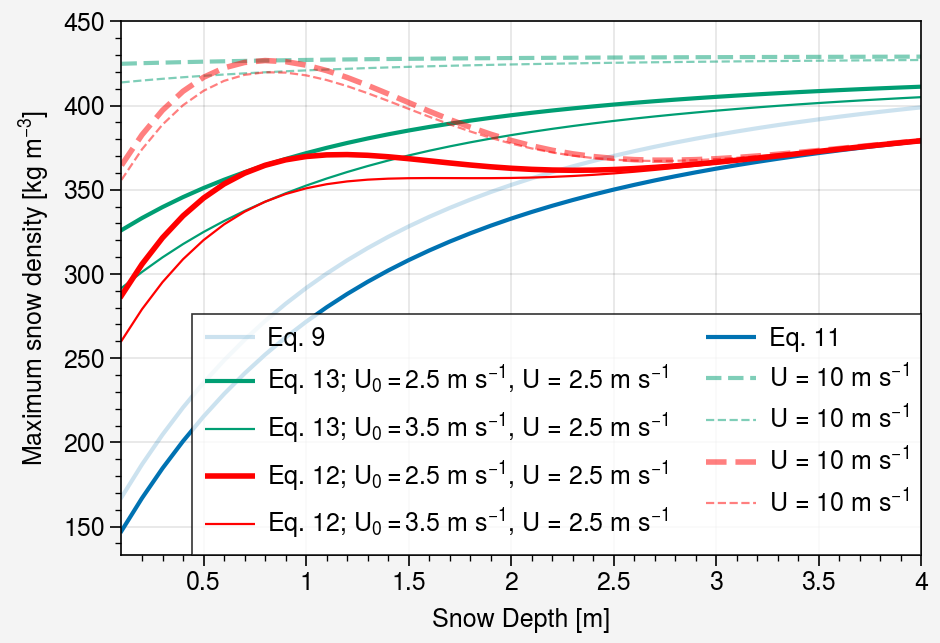

In [56]:
# fig, axs = pplt.subplots(refwidth=4, refaspect=1.5)
fig, axs = pplt.subplots(refwidth=4, refaspect=1.5)

ax = axs[0]

sd = pplt.arange(0.1, 4, 0.1)

lw_TVC = 0.8

ax.plot(sd, BR06_dry(sd), label='Eq. 9', alpha=0.2)

ax.plot(sd, rho_m(sd), label='Eq. 11', c='C0')
ax.plot(sd, rho_max_wind(sd, 2.5), label='Eq. 13; $U_0 = 2.5$ m s$^{-1}$, U = 2.5 m s$^{-1}$', c='C2')
# ax.plot(sd, rho_max_wind(sd, 5), label='$\\rho_{max,wind}$ (U = 5 m s$^{-1}$)', c='C2', ls='--', alpha=0.5)
ax.plot(sd, rho_max_wind(sd, 10), label='U = 10 m s$^{-1}$', c='C2', ls='--', alpha=0.5)

ax.plot(sd, rho_max_wind_TVC(sd, 2.5), label='Eq. 13; $U_0 = 3.5$ m s$^{-1}$, U = 2.5 m s$^{-1}$', c='C2', lw=lw_TVC)
# ax.plot(sd, rho_max_wind_TVC(sd, 5), label='$\\rho_{max,wind~(TVC)}$ (U = 5 m s$^{-1}$)', c='C2', ls='--', alpha=0.5, lw=lw_TVC)
ax.plot(sd, rho_max_wind_TVC(sd, 10), label='U = 10 m s$^{-1}$', c='C2', ls='--', alpha=0.5, lw=lw_TVC)

ax.plot(sd, rho_max_gauss(sd, 2.5), label='Eq. 12; $U_0 = 2.5$ m s$^{-1}$, U = 2.5 m s$^{-1}$', c='red', lw=2)
# ax.plot(sd, rho_max_gauss(sd, 5), label='$\\rho_{max,gauss}$ (U = 5 m s$^{-1}$)', c='red', ls='--', alpha=0.5, lw=2)
ax.plot(sd, rho_max_gauss(sd, 10), label='U = 10 m s$^{-1}$', c='red', ls='--', alpha=0.5, lw=2)

ax.plot(sd, rho_max_gauss_TVC(sd, 2.5), label='Eq. 12; $U_0 = 3.5$ m s$^{-1}$, U = 2.5 m s$^{-1}$', c='red', lw=lw_TVC)
# ax.plot(sd, rho_max_gauss_TVC(sd, 5), label='$\\rho_{max,gauss~(TVC)}$ (U = 5 m s$^{-1}$)', c='red', ls='--', alpha=0.5, lw=lw_TVC)
ax.plot(sd, rho_max_gauss_TVC(sd, 10), label='U = 10 m s$^{-1}$', c='red', ls='--', alpha=0.5, lw=lw_TVC)

# ax.axvline(0.5, color='black', linestyle='--', lw=1)


ax.format(
    xlabel='Snow Depth [m]',
    ylabel='Maximum snow density [kg m$^{-3}$]',
    ymax=450, 
)

# ax.legend(ncols=2, loc='t')
ax.legend(ncols=2)
# fig.save('img/rho_max_vs_sd_gauss_final_v2.jpg')
# fig.save('img/rho_max_vs_sd_gauss_final_v2.png')
# fig.save('img/rho_max_vs_sd_gauss_final_v2.pdf')

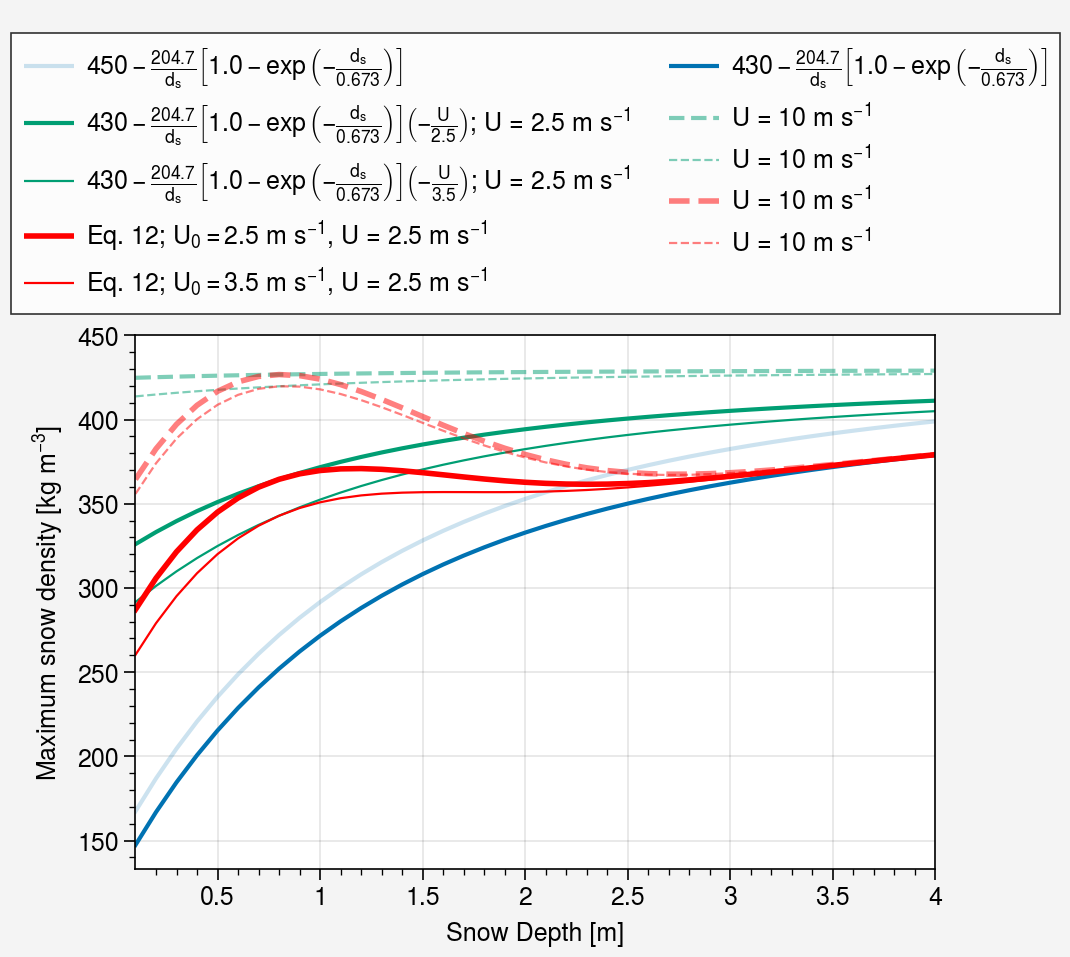

In [52]:
# fig, axs = pplt.subplots(refwidth=4, refaspect=1.5)
fig, axs = pplt.subplots(refwidth=4, refaspect=1.5)

ax = axs[0]

sd = pplt.arange(0.1, 4, 0.1)

lw_TVC = 0.8

ax.plot(sd, BR06_dry(sd), label='$450-\\frac{204.7}{d_s}\\left[1.0-\\exp \\left(-\\frac{d_s}{0.673}\\right)\\right]$', alpha=0.2)

ax.plot(sd, rho_m(sd), label='$430-\\frac{204.7}{d_s}\\left[1.0-\\exp \\left(-\\frac{d_s}{0.673}\\right)\\right]$', c='C0')
ax.plot(sd, rho_max_wind(sd, 2.5), label='$430-\\frac{204.7}{d_s}\\left[1.0-\\exp \\left(-\\frac{d_s}{0.673}\\right)\\right]\\left(-\\frac{U}{2.5}\\right)$; U = 2.5 m s$^{-1}$', c='C2')
# ax.plot(sd, rho_max_wind(sd, 5), label='$\\rho_{max,wind}$ (U = 5 m s$^{-1}$)', c='C2', ls='--', alpha=0.5)
ax.plot(sd, rho_max_wind(sd, 10), label='U = 10 m s$^{-1}$', c='C2', ls='--', alpha=0.5)

ax.plot(sd, rho_max_wind_TVC(sd, 2.5), label='$430-\\frac{204.7}{d_s}\\left[1.0-\\exp \\left(-\\frac{d_s}{0.673}\\right)\\right]\\left(-\\frac{U}{3.5}\\right)$; U = 2.5 m s$^{-1}$', c='C2', lw=lw_TVC)
# ax.plot(sd, rho_max_wind_TVC(sd, 5), label='$\\rho_{max,wind~(TVC)}$ (U = 5 m s$^{-1}$)', c='C2', ls='--', alpha=0.5, lw=lw_TVC)
ax.plot(sd, rho_max_wind_TVC(sd, 10), label='U = 10 m s$^{-1}$', c='C2', ls='--', alpha=0.5, lw=lw_TVC)

ax.plot(sd, rho_max_gauss(sd, 2.5), label='Eq. 12; $U_0 = 2.5$ m s$^{-1}$, U = 2.5 m s$^{-1}$', c='red', lw=2)
# ax.plot(sd, rho_max_gauss(sd, 5), label='$\\rho_{max,gauss}$ (U = 5 m s$^{-1}$)', c='red', ls='--', alpha=0.5, lw=2)
ax.plot(sd, rho_max_gauss(sd, 10), label='U = 10 m s$^{-1}$', c='red', ls='--', alpha=0.5, lw=2)

ax.plot(sd, rho_max_gauss_TVC(sd, 2.5), label='Eq. 12; $U_0 = 3.5$ m s$^{-1}$, U = 2.5 m s$^{-1}$', c='red', lw=lw_TVC)
# ax.plot(sd, rho_max_gauss_TVC(sd, 5), label='$\\rho_{max,gauss~(TVC)}$ (U = 5 m s$^{-1}$)', c='red', ls='--', alpha=0.5, lw=lw_TVC)
ax.plot(sd, rho_max_gauss_TVC(sd, 10), label='U = 10 m s$^{-1}$', c='red', ls='--', alpha=0.5, lw=lw_TVC)

# ax.axvline(0.5, color='black', linestyle='--', lw=1)


ax.format(
    xlabel='Snow Depth [m]',
    ylabel='Maximum snow density [kg m$^{-3}$]',
    ymax=450, 
)

ax.legend(ncols=2, loc='t')
# fig.save('img/rho_max_vs_sd_gauss_final_v2.jpg')
# fig.save('img/rho_max_vs_sd_gauss_final_v2.png')
# fig.save('img/rho_max_vs_sd_gauss_final_v2.pdf')

## Compare with obs

### Get snowpits density Bylot

In [15]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'
df = pd.read_csv(path_obs+'/Bylot/BylotDensity2015.csv', sep=';', parse_dates=['Date'], index_col=['Date'])
df

/tmp/ipykernel_1223184/2041260201.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path_obs+'/Bylot/BylotDensity2015.csv', sep=';', parse_dates=['Date'], index_col=['Date'])


,Location,Height cm,Density kg m-3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
Date,,,,,,,,,,,,,
2015-05-12,Tundra,25.5,174.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-12,Tundra,22.5,269.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-12,Tundra,19.5,365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-12,Tundra,16.5,415.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-12,Tundra,13.5,407.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
locations = ['Wet 0', 'TUNDRA', 'Pit 3', 'COTO 1G', 'COTO 2', 'Plaine1', 'Plaine2', 'Bombe', 'attk01']

In [17]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'

df_list_all = []
for location in locations:
    df_list_site = []
    for year in ['2014', '2015', '2017', '2018', '2019']:
    # for year in ['2019']:
        df = pd.read_csv(path_obs+'/Bylot/BylotDensity'+year+'.csv', sep=';', parse_dates=['Date'], index_col=['Date'])
        df_list_site.append(
            df[
            (df['Location'] == location.capitalize()) | \
            (df['Location'] == location.lower()) | \
            (df['Location'] == location.upper()) | \
            (df['Location'] == location.replace(" ", ""))
            ]
        )
    df_list_all.append(df_list_site)

/tmp/ipykernel_1223184/1838493260.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path_obs+'/Bylot/BylotDensity'+year+'.csv', sep=';', parse_dates=['Date'], index_col=['Date'])
/tmp/ipykernel_1223184/1838493260.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path_obs+'/Bylot/BylotDensity'+year+'.csv', sep=';', parse_dates=['Date'], index_col=['Date'])
/tmp/ipykernel_1223184/1838493260.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path_obs+'/Bylot/BylotDensity'+year+'.csv', sep=';', parse_dates=['Date'], index_

In [18]:
snd_list = []
dz_list = []
for i, location in enumerate(locations):
    print(i)
    print(location)
    for site_df in df_list_all[i]:
        if not site_df.empty:
            print(site_df.index[0])
            dz = site_df['Height cm'].iloc[0]-site_df['Height cm'].iloc[-1]
            snd = np.trapz(site_df['Density kg m-3'], -site_df['Height cm'])/dz
            snd_list.append(snd)
            dz_list.append(dz)
            print('Obs : ' + str(snd))
            print()

0
Wet 0
2014-05-14 00:00:00
Obs : 369.8720930232558

2015-05-12 00:00:00
Obs : 316.92

2017-05-14 00:00:00
Obs : 313.7087912087912

2018-05-14 00:00:00
Obs : 276.72549019607845

2019-05-15 00:00:00
Obs : 347.1904411764706

1
TUNDRA
2014-05-14 00:00:00
Obs : 298.1296296296296

2015-05-12 00:00:00
Obs : 310.01063829787233

2017-05-13 00:00:00
Obs : 342.02702702702703

2018-05-14 00:00:00
Obs : 282.1279069767442

2019-05-13 00:00:00
Obs : 300.5924242424242

2
Pit 3
2014-05-16 00:00:00
Obs : 219.09375

2015-05-13 00:00:00
Obs : 247.4

3
COTO 1G
2015-05-18 00:00:00
Obs : 258.0660377358491

4
COTO 2
2015-05-18 00:00:00
Obs : 298.0135135135135

5
Plaine1
2014-05-18 00:00:00
Obs : 315.234693877551

2017-05-18 00:00:00
Obs : 323.91279069767444

2018-05-16 00:00:00
Obs : 324.53061224489795

6
Plaine2
2014-05-18 00:00:00
Obs : 258.6578947368421

2017-05-18 00:00:00
Obs : 297.28846153846155

7
Bombe
2014-05-19 00:00:00
Obs : 273.23636363636365

8
attk01
2018-05-10 00:00:00
Obs : 213.08387096774194

### Get snowpits density Umiujac

In [19]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Umiujaq/Domine-etal_2024/datasets'
filename = 'Umiujaq_snow_density.tab'
df = pd.read_csv(path_obs+'/'+filename, sep='\t', parse_dates=['Date'], index_col=['Date'], skiprows=31)
df = df.drop(columns=['Event'])
df

,Latitude,Longitude,No,Vegetation type,Snow h [m],Density snow [kg/m**3]
Date,,,,,,
2012-03-14,56.540667,-76.442722,1,tundra,0.72,331
2012-03-14,56.540667,-76.442722,1,tundra,0.67,298
2012-03-14,56.540667,-76.442722,1,tundra,0.62,306
2012-03-14,56.540667,-76.442722,1,tundra,0.57,308
2012-03-14,56.540667,-76.442722,1,tundra,0.52,304
...,...,...,...,...,...,...
2018-04-08,56.553083,-76.472583,1,forest,0.21,447
2018-04-08,56.553083,-76.472583,1,forest,0.18,418
2018-04-08,56.553083,-76.472583,1,forest,0.15,385


In [20]:
tundra_df = df[df['Vegetation type'] == 'tundra']
forest_df = df[df['Vegetation type'] == 'forest']
forest_df

,Latitude,Longitude,No,Vegetation type,Snow h [m],Density snow [kg/m**3]
Date,,,,,,
2015-03-29,56.540417,-76.424083,1,forest,0.86,162
2015-03-29,56.540417,-76.424083,1,forest,0.83,186
2015-03-29,56.540417,-76.424083,1,forest,0.80,225
2015-03-29,56.540417,-76.424083,1,forest,0.77,232
2015-03-29,56.540417,-76.424083,1,forest,0.74,246
...,...,...,...,...,...,...
2018-04-08,56.553083,-76.472583,1,forest,0.21,447
2018-04-08,56.553083,-76.472583,1,forest,0.18,418
2018-04-08,56.553083,-76.472583,1,forest,0.15,385


In [21]:
tundra_df = tundra_df.drop(columns=['Vegetation type'])
forest_df = forest_df.drop(columns=['Vegetation type'])

In [22]:
# Function to perform trapezoidal integration
def trapezoidal_integration(df):
    dz = df['Snow h [m]'].values[0]-df['Snow h [m]'].values[-1]
    return np.trapz(df['Density snow [kg/m**3]'], -df['Snow h [m]'])/dz

In [23]:
tundra_df_integrated = tundra_df.groupby(['Date', 'No', 'Latitude']).apply(trapezoidal_integration).reset_index(name='Integrated Density').dropna() \
                        .set_index(['Date', 'No', 'Latitude'])
tundra_df_max = tundra_df.groupby(['Date', 'No', 'Latitude']).max().reindex(tundra_df_integrated.index)
tundra_df_integrated['Snow h [m]'] = tundra_df_max['Snow h [m]'].values
tundra_df_integrated

/tmp/ipykernel_1223184/2985463685.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return np.trapz(df['Density snow [kg/m**3]'], -df['Snow h [m]'])/dz


Integrated Density  Snow h [m]
Date       No Latitude                                 
2012-03-14 1  56.540667          324.208333       0.720
2012-03-16 1  56.559167          368.113636       0.500
           2  56.559083          274.269231       0.360
2012-03-18 1  56.539389          336.219178       0.780
2012-03-19 1  56.545472          301.566667       0.200
2013-02-15 1  56.558694          307.372881       0.610
2013-02-16 1  56.559806          350.861538       0.690
2014-02-24 1  56.536750          394.702703       1.130
           2  56.533222          337.150000       0.430
2014-02-25 1  56.558833          364.902597       0.840
           2  56.560278          362.556452       0.660
2014-02-27 1  56.569417          392.480392       0.570
           2  56.569083          350.568182       0.280
2015-03-25 1  56.560028          263.240741       0.235
           2  56.559750          321.395833       0.760
2015-03-26 1  56.541611          270.229730       0.430
2015-03-27 2  56.559756          275.692308       0.705
2016-01-24 1  56.567389          348.534722       0.390
           2  56.568722          340.446524       1.105
2016-03-19 1  56.559139          328.680412       1.020
              56.564389          310.725000       0.840
2017-03-27 1  56.560361          412.140625       0.450
2017-03-28 1  56.568972          355.586466       0.715
           2  56.567389          435.706897       0.630
2017-03-29 1  56.559139          347.580000       0.560
2017-03-30 1  56.559528          421.810078       0.675
           2  56.558722          387.764151       0.580
2018-04-06 1  56.558694          371.934426       1.240
2019-03-20 1  56.559111          307.830769       0.720
2019-03-22 1  56.558833          335.616279       0.510

In [24]:
forest_df_integrated = forest_df.groupby(['Date', 'No', 'Latitude']).apply(trapezoidal_integration).reset_index(name='Integrated Density').dropna() \
                        .set_index(['Date', 'No', 'Latitude'])
forest_df_max = forest_df.groupby(['Date', 'No', 'Latitude']).max().reindex(forest_df_integrated.index)
forest_df_integrated['Snow h [m]'] = forest_df_max['Snow h [m]'].values
forest_df_integrated

,,,Integrated Density,Snow h [m]
Date,No,Latitude,,
2015-03-29,1,56.540417,294.092593,0.860
2016-01-28,1,56.553167,273.410042,1.215
2017-03-31,1,56.553056,339.089404,1.700
2018-04-08,1,56.553083,362.615385,1.880


### CDP

In [25]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'
site = 'cdp'
site_longname = 'Col de Porte, France'
y_start = 2002
y_end = 2014

ds_h_obs = xr.open_dataset(path_obs+'/obs_insitu_'+site+'_1994_'+str(y_end)+'.nc').load()
ds_d_obs = ds_h_obs.resample(time='D').mean().load()
ds_h_obs

<xarray.Dataset> Size: 8MB
Dimensions:   (time: 175320, sdepth: 3)
Coordinates:
  * time      (time) datetime64[ns] 1MB 1994-10-01T01:00:00 ... 2014-10-01
  * sdepth    (sdepth) float32 12B 0.1 0.2 0.5
Data variables:
    albs      (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    snd_auto  (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    snd_man   (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    snw_auto  (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    snw_man   (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    ts        (time) float32 701kB 11.12 9.668 8.029 ... 7.532 7.532 8.029
    tsl       (time, sdepth) float32 2MB 11.95 12.28 12.23 ... 12.95 12.83 12.8

### Snow temperature

In [26]:
from snowpyt import pit_class as pc

Theoric snow temperature within CLASSIC: https://cccma.gitlab.io/classic/snowHeatCond_8f90.html#details

In [27]:
import os

def sorted_directory_listing_with_os_listdir(directory):
    items = os.listdir(directory)
    sorted_items = sorted(items)
    return sorted_items

In [28]:
path_lejeune2019 = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/CRYOBSCLIM_CDP'
mypath = path_lejeune2019+'/CRYOBSCLIM.CDP.2018.SnowProfile/SnowProfile/'
files = sorted_directory_listing_with_os_listdir(mypath)

In [29]:
tsn_obs_profile_list = []
depth_obs_profile_list = []
tsn_obs = []
dens_obs_profile_list = []
depth_dens_obs_profile_list = []
dens_obs = []
date_obs = []
for file in files:
    p = pc.Snowpit()
    p.caaml_file = path_lejeune2019+'/CRYOBSCLIM.CDP.2018.SnowProfile/SnowProfile/'+file
    p.import_caamlv6(print2term=False)
    # Temperature
    try:
        tsn_obs.append(np.trapz(p.temperature_profile.temp, x=-p.temperature_profile.depth)/(p.temperature_profile.depth[0]-p.temperature_profile.depth[-1]))
        tsn_obs_profile_list.append(list(p.temperature_profile.temp))
        depth_obs_profile_list.append(list(p.temperature_profile.depth))
    except AttributeError:
        tsn_obs.append(np.nan)
        tsn_obs_profile_list.append([np.nan])
        depth_obs_profile_list.append([np.nan])
                       
    # Density
    try:
        dens_obs.append(np.trapz(p.density_profile.density, x=-p.density_profile.depth)/(p.density_profile.depth[0]-p.density_profile.depth[-1]))
        dens_obs_profile_list.append(list(p.density_profile.density))
        depth_dens_obs_profile_list.append(list(p.density_profile.depth))
    except AttributeError:
        dens_obs.append(np.nan)
        dens_obs_profile_list.append([np.nan])
        depth_dens_obs_profile_list.append([np.nan])

    date_obs.append(p.metadata.date)
    # p.plot(plot_order=['density', 'temperature', 'stratigraphy', 'hardness'])

/tmp/ipykernel_1223184/2027953912.py:24: RuntimeWarning: invalid value encountered in scalar divide
  dens_obs.append(np.trapz(p.density_profile.density, x=-p.density_profile.depth)/(p.density_profile.depth[0]-p.density_profile.depth[-1]))
/tmp/ipykernel_1223184/2027953912.py:24: RuntimeWarning: invalid value encountered in scalar divide
  dens_obs.append(np.trapz(p.density_profile.density, x=-p.density_profile.depth)/(p.density_profile.depth[0]-p.density_profile.depth[-1]))
/tmp/ipykernel_1223184/2027953912.py:24: RuntimeWarning: invalid value encountered in scalar divide
  dens_obs.append(np.trapz(p.density_profile.density, x=-p.density_profile.depth)/(p.density_profile.depth[0]-p.density_profile.depth[-1]))
/tmp/ipykernel_1223184/2027953912.py:24: RuntimeWarning: invalid value encountered in scalar divide
  dens_obs.append(np.trapz(p.density_profile.density, x=-p.density_profile.depth)/(p.density_profile.depth[0]-p.density_profile.depth[-1]))
/tmp/ipykernel_1223184/2027953912.py:24:

In [30]:
d = {'tsn': tsn_obs}
# df_tsn = pd.DataFrame(data=d, index=pd.to_datetime(date_obs).tz_convert('Europe/Paris').tz_localize(None))
df_tsn = pd.DataFrame(data=d, index=pd.to_datetime(date_obs).tz_localize(None) + pd.Timedelta(hours=2)) # to avoid the day light savings adjustment
df_tsn = df_tsn.dropna()
ds_tsn_loc = df_tsn.to_xarray()
ds_tsn_loc = ds_tsn_loc.rename({'index': 'time'})
ds_tsn_loc = ds_tsn_loc.reindex({'time': pd.date_range(ds_tsn_loc.tsn.time[0].values, ds_tsn_loc.tsn.time[-1].values, freq='H')})

In [31]:
d = {'tsn': tsn_obs}
df_tsn = pd.DataFrame(data=d, index=pd.to_datetime(date_obs).tz_localize(None))
df_tsn = df_tsn.dropna()
ds_tsn = df_tsn.to_xarray()
ds_tsn = ds_tsn.rename({'index': 'time'})
ds_tsn = ds_tsn.reindex({'time': pd.date_range(ds_tsn.tsn.time[0].values, ds_tsn.tsn.time[-1].values, freq='H')})

In [32]:
ds_tsn_loc_d = ds_tsn_loc.tsn.resample(time='d').mean()
ds_tsn_d = ds_tsn.tsn.resample(time='d').mean()

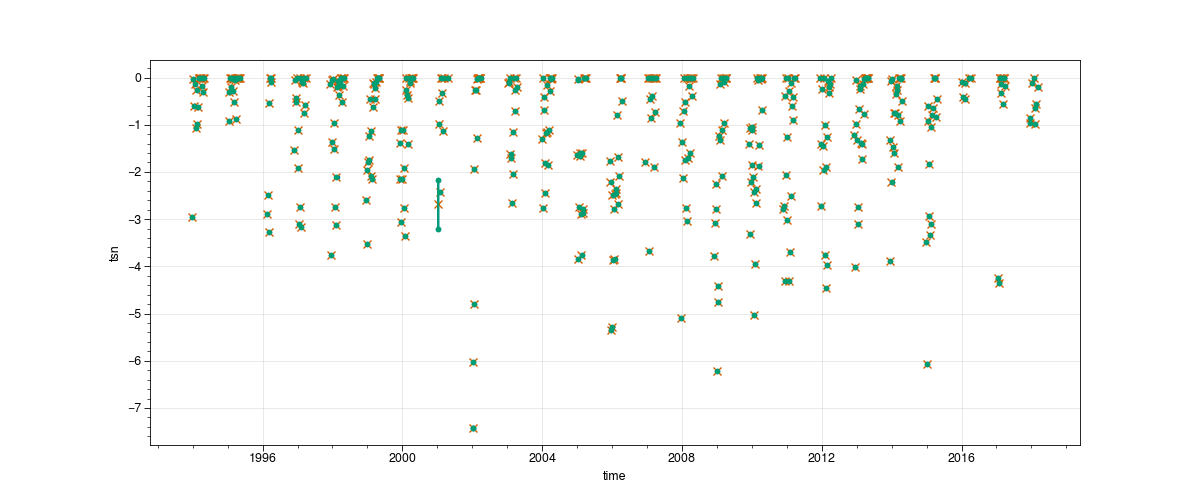

In [33]:
%matplotlib widget
plt.figure(figsize=(12,5))
# ds_hh.tsn.plot()
ds_tsn_loc.tsn.plot(marker='.')
ds_tsn_loc.tsn.resample(time='d').mean().plot(marker='x')
ds_tsn.tsn.plot(marker='.')
# ds_d_list[0].tsn.plot()


<a list of 1 Line2D objects>

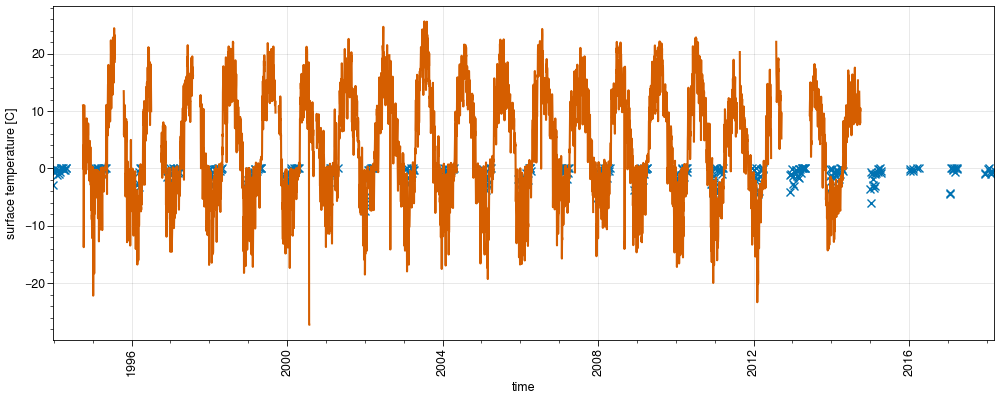

In [34]:
%matplotlib widget
pplt.subplots(figsize=(10, 4))
ds_tsn_d.plot(marker='x')
ds_d_obs.ts.plot()

<a list of 1 Line2D objects>

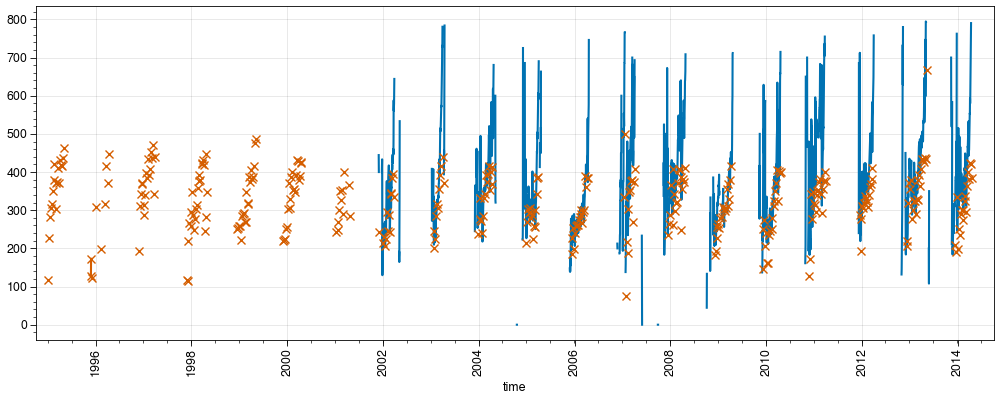

In [35]:
%matplotlib widget
pplt.subplots(figsize=(10, 4))
(ds_d_obs.snw_auto/ds_d_obs.snd_auto).where(ds_d_obs.snw_auto/ds_d_obs.snd_auto < 800).plot()
(ds_d_obs.snw_man/ds_d_obs.snd_man).plot(marker='x')

<a list of 1 Line2D objects>

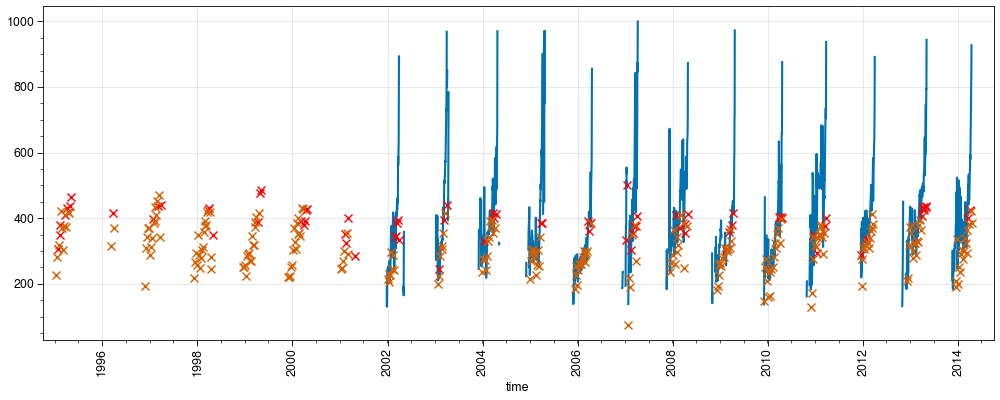

In [36]:
%matplotlib widget
pplt.subplots(figsize=(10, 4))
(ds_d_obs.snw_auto/ds_d_obs.snd_auto).where(ds_d_obs.snw_auto/ds_d_obs.snd_auto < 1000).where(ds_d_obs.snd_auto > 0.1).plot()
(ds_d_obs.snw_man/ds_d_obs.snd_man).where(ds_tsn_d >= 0).plot(marker='x', color='red')
(ds_d_obs.snw_man/ds_d_obs.snd_man).where(ds_tsn_d < 0).plot(marker='x')

<a list of 1 Line2D objects>

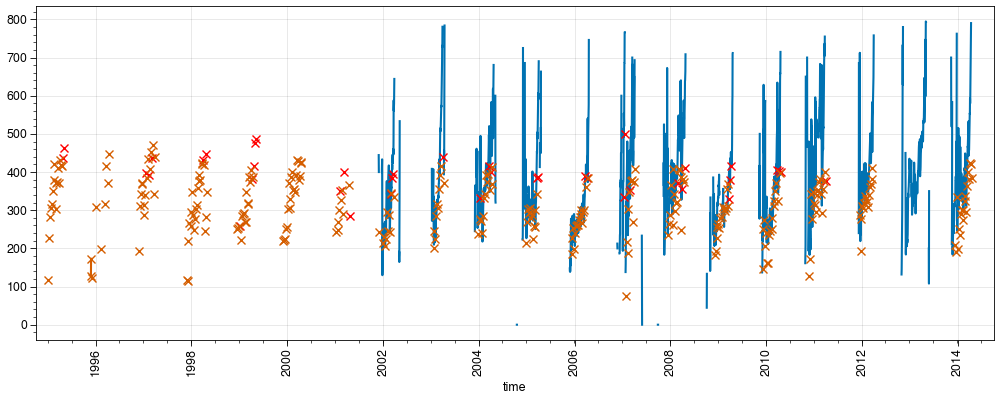

In [37]:
%matplotlib widget
pplt.subplots(figsize=(10, 4))
(ds_d_obs.snw_auto/ds_d_obs.snd_auto).where(ds_d_obs.snw_auto/ds_d_obs.snd_auto < 800).plot()
(ds_d_obs.snw_man/ds_d_obs.snd_man).where(ds_d_obs.ts >= 0).plot(marker='x', color='red')
(ds_d_obs.snw_man/ds_d_obs.snd_man).where(ds_d_obs.ts < 0).plot(marker='x')

### Royer database 

- Data: https://nordicana.cen.ulaval.ca/dpage.aspx?doi=45705CE-98FC517D461E4C25 (dowloaded 06/08/2024)
- Paper: https://doi.org/10.1080/11956860.2021.1898775

In [38]:
path = '~/Dropbox/data/Snowpits_Canada'
folder1 = 'ds_000600108'
folder2 = 'ds_000600147'
file1 = 'Base_de_données_neigeV2.csv'
file2 = 'Transect_mesures_neige_SD-SWE-D.csv'

In [39]:
df1 = pd.read_csv(path+'/'+folder1+'/'+file1, sep=';', parse_dates=['Date'])
df1

,Site,#Sub-site,Date,Latitude (°N),Longitude (°W),SD (cm),SWE (mm),Density (kg m-3),Depth hoar (cm),Depth hoar fraction,Env. type and comments,Unnamed: 11,Unnamed: 12
0,Forêt Montmorency,SP1,2012-03-06,47.32,-71.15,110.0,241.55,219.59,28.0,0.255,"Moss, grass, stumps, etc",NaN,NaN
1,Forêt Montmorency,SP2,2012-03-07,47.32,-71.15,112.0,275.81,246.26,22.0,0.196,NaN,NaN,NaN
2,Forêt Montmorency,MOREX3_SP1,2016-03,47.32,-71.15,121.0,319.09,263.71,40.0,0.331,Several ice crusts,NaN,NaN
3,Forêt Montmorency,MOREX3_SP2,2016-03,47.32,-71.15,122.0,328.18,269.00,31.0,0.254,Clearing,NaN,NaN
4,Forêt Montmorency,SP1,2017-03,47.32,-71.15,80.0,244.10,305.13,25.0,0.313,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,Ward Hut,WH1,2019-06-08,83.09,-74.16,NaN,NaN,NaN,5.0,0.192,NaN,NaN,NaN
278,Ward Hut,Lake-S1,2019-06-08,83.09,-74.16,NaN,NaN,NaN,15.0,0.500,NaN,NaN,NaN
279,Alert,NaN,2000-04,82.50,-62.35,40.3,144.68,359.01,10.0,0.248,"From Domine et al., 2002, Atmos Environ. 36(15...",NaN,NaN
280,Eureka,NaN,2011-04,80.00,-84.00,23.9,67.00,246.00,7.0,0.298,"From Saberi et al., 2017, Remote Sens. 9(12)",NaN,NaN


In [40]:
# Split data by latitude zones
df1_47_58 = df1[(df1['Latitude (°N)'] >= 47) & (df1['Latitude (°N)'] < 58)]
df1_58_74 = df1[(df1['Latitude (°N)'] >= 58) & (df1['Latitude (°N)'] < 74)]
df1_over_74 = df1[df1['Latitude (°N)'] >= 74]

In [41]:
df1_47_58

,Site,#Sub-site,Date,Latitude (°N),Longitude (°W),SD (cm),SWE (mm),Density (kg m-3),Depth hoar (cm),Depth hoar fraction,Env. type and comments,Unnamed: 11,Unnamed: 12
0,Forêt Montmorency,SP1,2012-03-06,47.32,-71.15,110.0,241.55,219.59,28.0,0.255,"Moss, grass, stumps, etc",NaN,NaN
1,Forêt Montmorency,SP2,2012-03-07,47.32,-71.15,112.0,275.81,246.26,22.0,0.196,NaN,NaN,NaN
2,Forêt Montmorency,MOREX3_SP1,2016-03,47.32,-71.15,121.0,319.09,263.71,40.0,0.331,Several ice crusts,NaN,NaN
3,Forêt Montmorency,MOREX3_SP2,2016-03,47.32,-71.15,122.0,328.18,269.00,31.0,0.254,Clearing,NaN,NaN
4,Forêt Montmorency,SP1,2017-03,47.32,-71.15,80.0,244.10,305.13,25.0,0.313,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Schefferville,Sc_L6_SP1,2008-02,54.90,-66.70,100.0,247.73,247.73,42.0,0.420,NaN,NaN,NaN
176,Schefferville,Sc_L7_SP1,2008-02,54.90,-66.70,80.0,223.65,279.56,41.0,0.513,NaN,NaN,NaN
177,Schefferville,Sc_L8_SP1,2008-02,54.90,-66.70,66.0,135.63,205.50,35.0,0.530,NaN,NaN,NaN
178,Schefferville,Sc_L8_SP2,2008-02,54.90,-66.70,42.0,NaN,NaN,NaN,NaN,Lake,NaN,NaN


In [42]:
contains_shrub = df1_47_58['Env. type and comments'].str.contains(r'shrub|bushes|grass|forest|Twings|Dwarf|birch|salix|Hummock', case=False, na=False)
df1_47_58_with_shrub = df1_47_58[contains_shrub]
df1_47_58_without_shrub = df1_47_58[~contains_shrub]

In [43]:
contains_shrub.sum()

35

In [44]:
df1_47_58_with_shrub

,Site,#Sub-site,Date,Latitude (°N),Longitude (°W),SD (cm),SWE (mm),Density (kg m-3),Depth hoar (cm),Depth hoar fraction,Env. type and comments,Unnamed: 11,Unnamed: 12
0,Forêt Montmorency,SP1,2012-03-06,47.32,-71.15,110.0,241.55,219.59,28.0,0.255,"Moss, grass, stumps, etc",NaN,NaN
9,Forêt Montmorency,SP6,2017-03,47.32,-71.15,133.0,421.12,316.63,15.0,0.113,Forest refreeze crust,NaN,NaN
20,Baie James,BJ SP3,2013-03,53.70,-76.05,87.0,121.41,139.55,60.0,0.690,Shrub 15 cm,NaN,NaN
28,Baie James,15_BJ11,2015-02-18,53.70,-76.05,109.0,322.05,295.46,20.0,0.183,Open area - forest edge,NaN,NaN
29,Baie James,15_BJ12,2015-02-18,53.70,-76.05,118.0,378.99,321.18,35.0,0.297,Open area - forest edge,NaN,NaN
35,Baie James,15_BJ18,2015-02-20,53.70,-76.05,84.0,221.07,263.18,40.0,0.476,Open area - forest edge,NaN,NaN
36,Baie James,15_BJ19,2015-02-20,53.70,-76.05,87.0,211.21,242.77,40.0,0.460,Open area - forest edge,NaN,NaN
37,Baie James,15_BJ20,2015-02-20,53.70,-76.05,97.0,272.56,280.99,50.0,0.515,Open area - forest edge,NaN,NaN
38,Baie James,15_BJ21,2015-02-20,53.70,-76.05,94.0,267.98,285.09,NaN,NaN,Open area - forest edge,NaN,NaN
50,Umiujaq,HC_density-B,2012-03-14,56.55,-76.50,113.0,369.42,326.92,53.0,0.469,Pit 1b is more into the bushes and thicker (11...,NaN,NaN


In [45]:
df2 = pd.read_csv(path+'/'+folder2+'/'+file2, sep=';')
df2

,H_L5_SP4,Latitude,Longitude,SD (cm),Std SD (cm),SWE (mm),Std SWE (mm),Density (kg m-3),Std (kg m-3),Comments
0,Foret Montmorency,47.32,-71.15,112.31,39.11,335.19,115.40,301.41,93.98,NaN
1,Station,47.70,-73.70,NaN,NaN,202.00,NaN,NaN,NaN,Larue et al. 2018
2,Station,47.90,-73.70,77.00,NaN,NaN,NaN,262.34,NaN,Larue et al. 2018
3,Station,48.30,-74.09,77.00,NaN,272.00,NaN,353.25,NaN,Larue et al. 2018
4,Station,48.90,-74.20,83.00,NaN,277.00,NaN,333.73,NaN,Larue et al. 2018
5,Sept-Îles,50.32,-66.34,109.42,NaN,392.61,129.83,358.83,NaN,IPY data
6,H_L1_SP1,50.60,-66.38,184.00,NaN,NaN,NaN,306.49,NaN,IPY data
7,H_L1_SP2,51.00,-66.45,132.00,NaN,385.96,NaN,292.39,NaN,IPY data
8,H_L1_SP3,51.30,-66.51,84.00,NaN,225.34,NaN,268.26,NaN,IPY data
9,H_L1_SP4,51.70,-66.58,95.00,NaN,295.02,NaN,310.55,NaN,IPY data


In [46]:
# Split data by latitude zones
df2_47_58 = df2[(df2['Latitude'] >= 47) & (df2['Latitude'] < 58)]
df2_58_74 = df2[(df2['Latitude'] >= 58) & (df2['Latitude'] < 74)]
df2_over_74 = df2[df2['Latitude'] >= 74]

In [47]:
df2_47_58

,H_L5_SP4,Latitude,Longitude,SD (cm),Std SD (cm),SWE (mm),Std SWE (mm),Density (kg m-3),Std (kg m-3),Comments
0,Foret Montmorency,47.32,-71.15,112.31,39.11,335.19,115.40,301.41,93.98,NaN
1,Station,47.70,-73.70,NaN,NaN,202.00,NaN,NaN,NaN,Larue et al. 2018
2,Station,47.90,-73.70,77.00,NaN,NaN,NaN,262.34,NaN,Larue et al. 2018
3,Station,48.30,-74.09,77.00,NaN,272.00,NaN,353.25,NaN,Larue et al. 2018
4,Station,48.90,-74.20,83.00,NaN,277.00,NaN,333.73,NaN,Larue et al. 2018
5,Sept-Îles,50.32,-66.34,109.42,NaN,392.61,129.83,358.83,NaN,IPY data
6,H_L1_SP1,50.60,-66.38,184.00,NaN,NaN,NaN,306.49,NaN,IPY data
7,H_L1_SP2,51.00,-66.45,132.00,NaN,385.96,NaN,292.39,NaN,IPY data
8,H_L1_SP3,51.30,-66.51,84.00,NaN,225.34,NaN,268.26,NaN,IPY data
9,H_L1_SP4,51.70,-66.58,95.00,NaN,295.02,NaN,310.55,NaN,IPY data


## Plot

In [48]:
def plot_max_rho(ax):
    h2 = ax.plot(sd, BR06_wet(sd), label='Brown et al. (2006) wet snow')
    h1 = ax.plot(sd, BR06_dry(sd), label='Brown et al. (2006) dry snow')
    h3 = ax.plot(sd, TB90(sd), label='Tabler et al. (1990)')
    
    # Add the shaded rectangle
    ax.axvspan(0.6, sd[-1], color='lightgreen', alpha=0.3)
    
    # Add the vertical line at snow depth of 0.5
    ax.axvline(0.5, color='black', linestyle='--', lw=1)
    
    # Calculate and annotate the crossing values
    dry_crossing = BR06_dry(0.5)
    wet_crossing = BR06_wet(0.5)
    tb90_crossing = TB90(0.5)
    
    # Plot the intersection points
    ax.plot(0.5, dry_crossing, 'o', color='C1')
    ax.plot(0.5, wet_crossing, 'o', color='C0')
    ax.plot(0.5, tb90_crossing, 'o', color='C2')
    
    # Annotate the crossing values
    ax.text(0.6, dry_crossing, f'{dry_crossing:.1f}', verticalalignment='center', color='C1', zorder=20)
    ax.text(0.6, wet_crossing, f'{wet_crossing:.1f}', verticalalignment='center', color='C0', zorder=20)
    ax.text(0.6, tb90_crossing, f'{tb90_crossing:.1f}', verticalalignment='center', color='C2', zorder=20)

    return [h1, h2, h3]

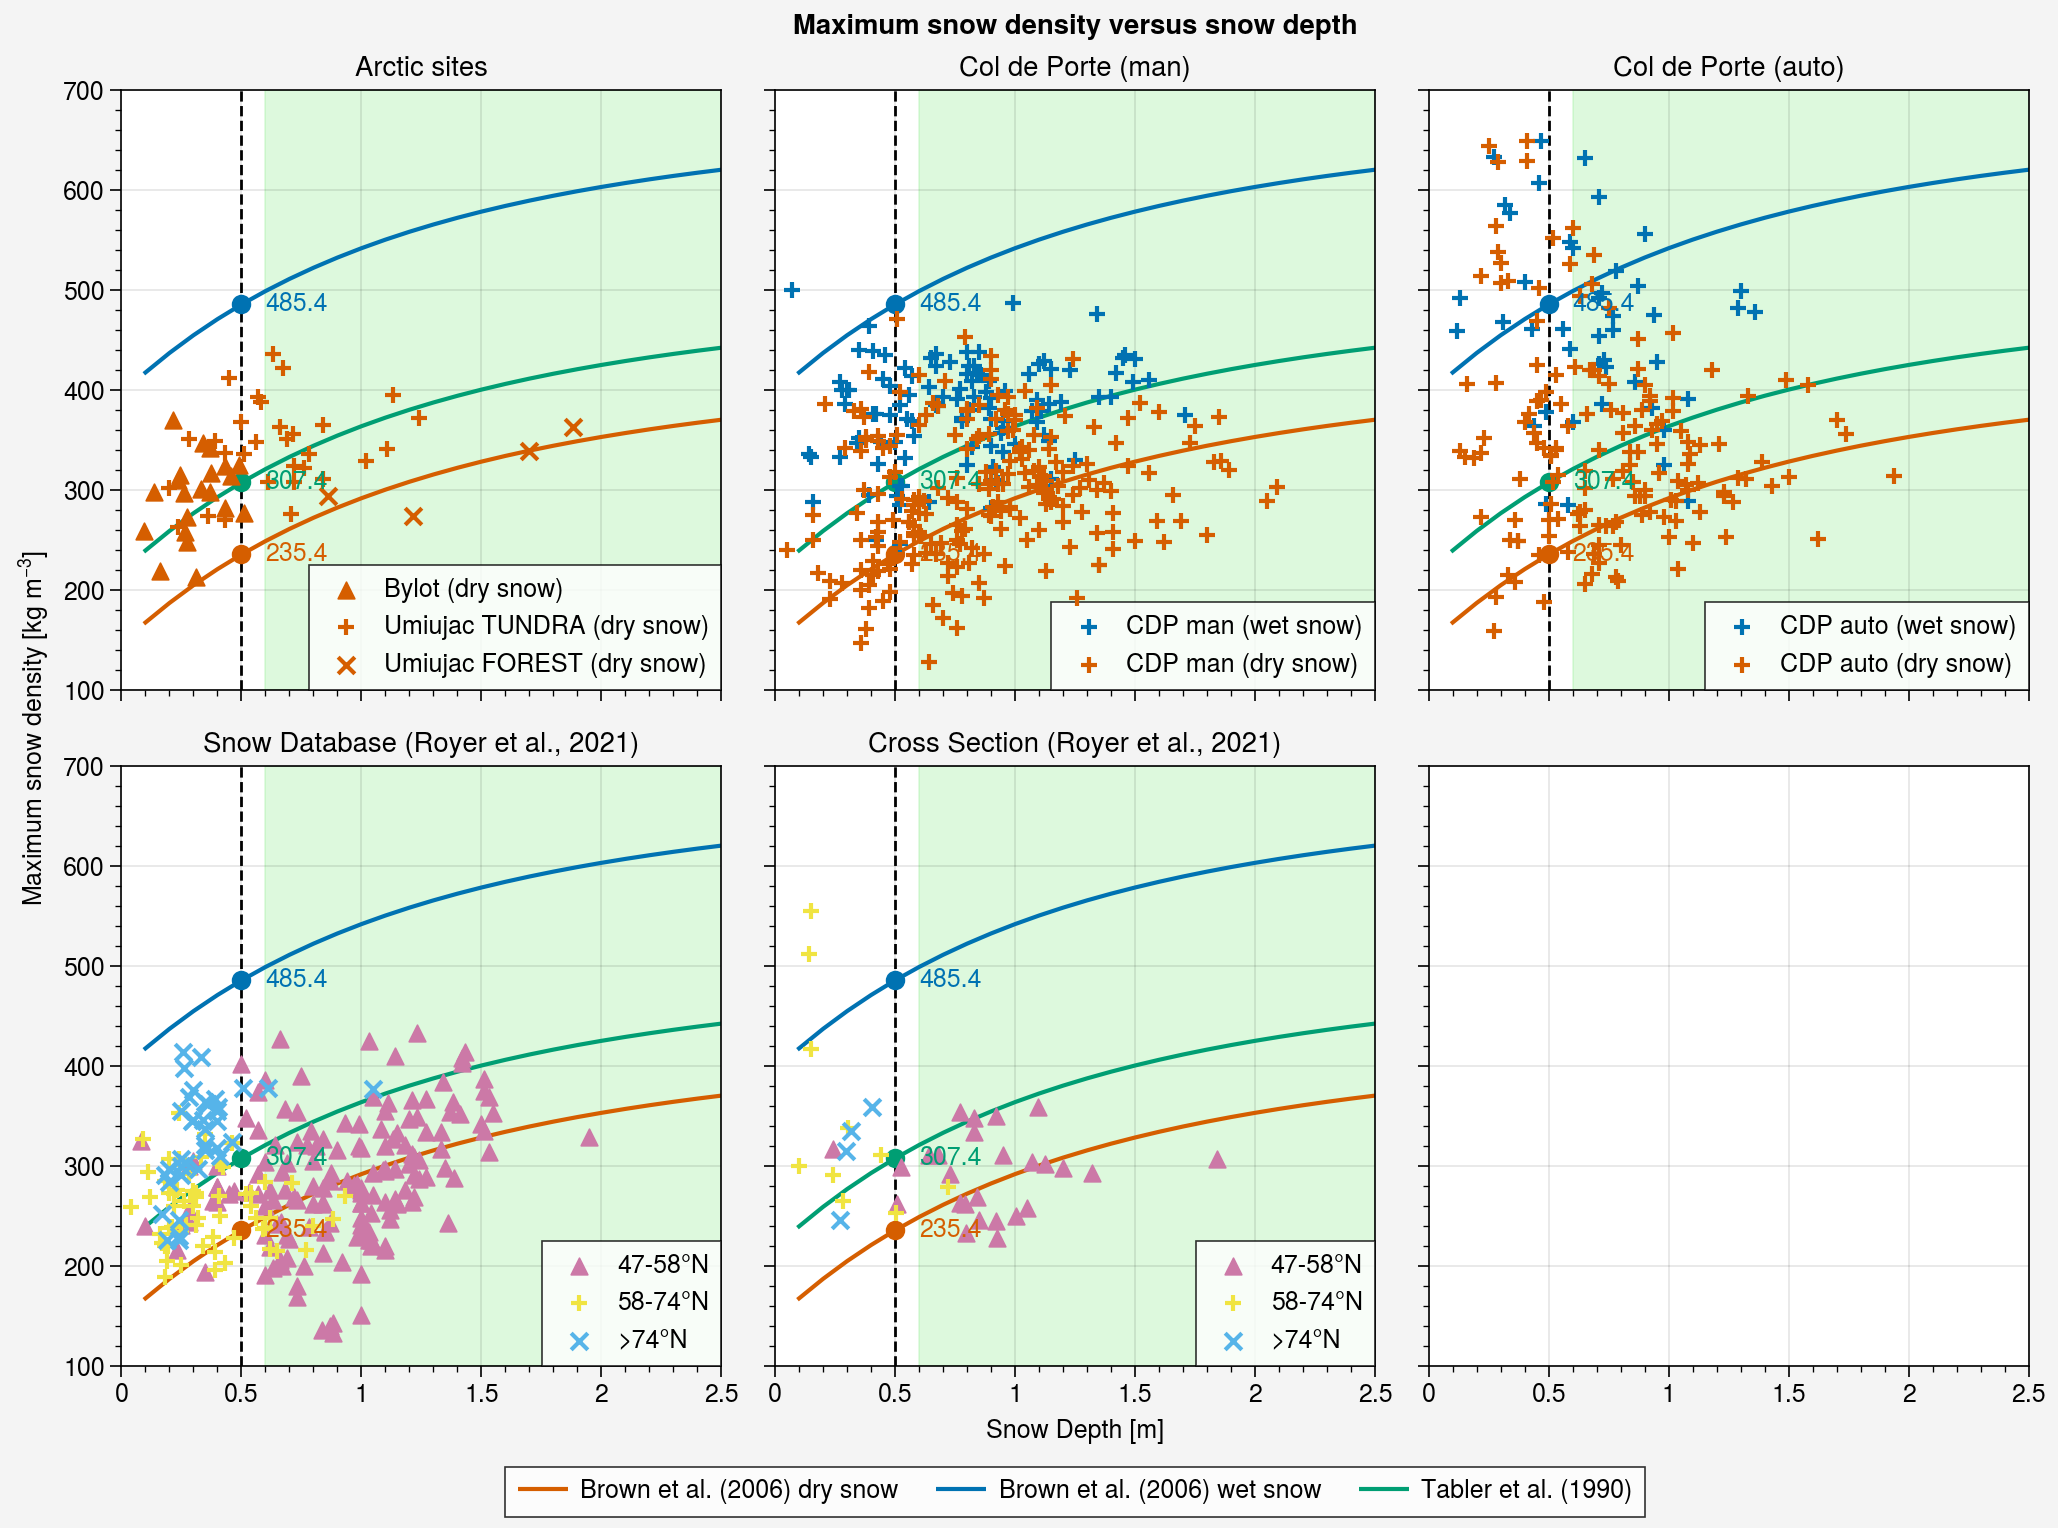

In [49]:
%matplotlib inline
fig, axs = pplt.subplots(nrows=2, ncols=3, refwidth=3, refaspect=1)

ax = axs[0]
h = plot_max_rho(ax)
temp_thr = -0.1 # °C
snd_thr = 0.1 # m

# Add Bylot snow pits
h1 = ax.scatter(np.array(dz_list)/100, snd_list, m='^', label='Bylot (dry snow)', zorder=10, c='C1')
h2 = ax.scatter(tundra_df_integrated['Snow h [m]'].values, tundra_df_integrated['Integrated Density'].values, 
           m='+', label='Umiujac TUNDRA (dry snow)', zorder=10, c='C1')
h3 = ax.scatter(forest_df_integrated['Snow h [m]'].values, forest_df_integrated['Integrated Density'].values, 
           m='x', label='Umiujac FOREST (dry snow)', zorder=10, c='C1')
ax.legend([h1, h2, h3], ncols=1)
ax.format(title='Arctic sites')


# CDP (man)
ax = axs[1]
plot_max_rho(ax)

h1 = ax.scatter(ds_d_obs.snd_man.where(ds_tsn_d >= temp_thr), (ds_d_obs.snw_man/ds_d_obs.snd_man).where(ds_tsn_d >= temp_thr), 
           m='+', label='CDP man (wet snow)', zorder=10, c='C0')
h2 = ax.scatter(ds_d_obs.snd_man.where(ds_tsn_d < temp_thr), (ds_d_obs.snw_man/ds_d_obs.snd_man).where(ds_tsn_d < temp_thr), 
           m='+', label='CDP man (dry snow)', zorder=10, c='C1')

ax.format(title='Col de Porte (man)')
ax.legend([h1, h2], ncols=1)

# CDP (auto)
ax = axs[2]
plot_max_rho(ax)

h1 = ax.scatter(ds_d_obs.snd_auto.where(ds_tsn_d >= temp_thr).where(ds_d_obs.snw_auto/ds_d_obs.snd_auto < 1000).where(ds_d_obs.snd_auto > snd_thr), (ds_d_obs.snw_auto/ds_d_obs.snd_auto).where(ds_d_obs.snw_auto/ds_d_obs.snd_auto < 1000).where(ds_d_obs.snd_auto > 0.1).where(ds_tsn_d >= 0), 
           m='+', label='CDP auto (wet snow)', zorder=10, c='C0')
h2 = ax.scatter(ds_d_obs.snd_auto.where(ds_tsn_d < temp_thr).where(ds_d_obs.snw_auto/ds_d_obs.snd_auto < 1000).where(ds_d_obs.snd_auto > snd_thr), (ds_d_obs.snw_auto/ds_d_obs.snd_auto).where(ds_d_obs.snw_auto/ds_d_obs.snd_auto < 1000).where(ds_d_obs.snd_auto > 0.1).where(ds_tsn_d < 0), 
           m='+', label='CDP auto (dry snow)', zorder=10, c='C1')
ax.format(title='Col de Porte (auto)')
ax.legend([h1, h2], ncols=1)


# Arctic database
ax = axs[3]
plot_max_rho(ax)
h1 = ax.scatter(df1_47_58['SD (cm)'].values/100, df1_47_58['Density (kg m-3)'].values, m='^', label='47-58°N', zorder=10)
h2 = ax.scatter(df1_58_74['SD (cm)'].values/100, df1_58_74['Density (kg m-3)'].values, m='+', label='58-74°N', zorder=10)
h3 = ax.scatter(df1_over_74['SD (cm)'].values/100, df1_over_74['Density (kg m-3)'].values, m='x', label='>74°N', zorder=10)
ax.legend([h1, h2, h3], ncols=1)
ax.format(title='Snow Database (Royer et al., 2021)')


# Arctic database
ax = axs[4]
plot_max_rho(ax)
h1 = ax.scatter(df2_47_58['SD (cm)'].values/100, df2_47_58['Density (kg m-3)'].values, m='^', label='47-58°N', zorder=10)
h2 = ax.scatter(df2_58_74['SD (cm)'].values/100, df2_58_74['Density (kg m-3)'].values, m='+', label='58-74°N', zorder=10)
h3 = ax.scatter(df2_over_74['SD (cm)'].values/100, df2_over_74['Density (kg m-3)'].values, m='x', label='>74°N', zorder=10)
ax.legend([h1, h2, h3], ncols=1)
ax.format(title='Cross Section (Royer et al., 2021)')


for ax in axs:
    ax.format(
        xlabel='Snow Depth [m]',
        ylabel='Maximum snow density [kg m$^{-3}$]',
        xlim=(0,2.5), ylim=(100, 700)
    )

fig.legend(h, loc='b')
fig.format(suptitle='Maximum snow density versus snow depth')
    
# fig.save('img/rho_max_vs_sd_obs.jpg')

# Time evolving snow density

In [50]:
      if (FI(I) > 0. .and. ZSNOW(I) > 0.0001 .and. &
          RHOSNO(I) < (RHOMAX(I) - 0.01)) then
        RHOOLD = RHOSNO(I)
        RHOSNO(I) = (RHOSNO(I) - RHOMAX(I)) * EXP( - 0.01 * DELT / 3600.0) + &
                    RHOMAX(I)

SyntaxError: invalid syntax (1327509453.py, line 1)

In [ ]:
def rho_aging(rho, rho_max, delt):
    return (rho - rho_max) * np.exp( - 0.01 * delt / 3600.0) + rho_max

In [ ]:
ds_h_obs

In [ ]:
site = 'cdp'
site_longname = 'Col de Porte, France'
y_start = 2002
y_end = 2014

# labels = ['peat_30min_ext', 'peat']
labels = [
    'TCZE_REF_TSNB_REF',   
    'TCZE_REF_TSNB_OP1',   
]

root_path = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowMIP/'+site+'/'
paths = [root_path+'run_'+label for label in labels]

ds_d_list = [xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths]
# ds_hh_list = [xr.open_mfdataset(path+'/*_halfhourly.nc').squeeze().load() for path in paths]

In [ ]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/"+site
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_Ref.nc')

In [ ]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [ ]:
for i in range(len(labels)):
    # ds_yr_list[i] = assign_center_depth(ds_yr_list[i], rsfile)
    # ds_mo_list[i] = assign_center_depth(ds_mo_list[i], rsfile)
    ds_d_list[i] = assign_center_depth(ds_d_list[i], rsfile)
    # ds_hh_list[i] = assign_center_depth(ds_hh_list[i], rsfile)

In [ ]:
ds_d_list[0].snwdens

In [ ]:
dry_crossing = BR06_dry(0.5)
wet_crossing = BR06_wet(0.5)
tb90_crossing = TB90(0.5)

In [ ]:
rho_max_TB90 = TB90(ds_d_obs.snd_auto.sel(time=period))

In [ ]:
rho_TB90 = rho_aging(ds_d_obs.snw_auto.sel(time=period)/ds_d_obs.snd_auto.sel(time=period), rho_max_TB90, 86400)

In [ ]:
%matplotlib widget
fig, axs = pplt.subplots(nrows=2, sharey=0, figsize=(10, 6))

# year = 2005
year = 2011
period = slice('11-'+str(year), '05-'+str(year+1))



ax = axs[0]

ax.plot(ds_d_obs.snd_auto.sel(time=period), label='Obs (auto)', c='dark grey')
ax.plot(ds_d_list[0].snd.sel(time=period), label='Model REF')
# ax.plot(ds_d_list[1].snd.sel(time=period), label='Model TSNBOT OP1', c='C0', ls='--')
ax.format(
    ylabel='Snow Depth [m]',
    # ylim=(50, 600),
)



ax = axs[1]

ax.plot(ds_d_obs.snw_auto.sel(time=period)/ds_d_obs.snd_auto.sel(time=period), label='Obs (auto)', c='dark grey')
ax.plot(ds_d_obs.snw_man.sel(time=period)/ds_d_obs.snd_man.sel(time=period), label='Obs (man)', c='dark grey', marker='x')
ax.plot(ds_d_list[0].snwdens.sel(time=period), label='Model REF')
# ax.plot(ds_d_list[1].snwdens.sel(time=period), label='Model TSNBOT OP1', c='C0', ls='--')

rho_max_TB90 = TB90(ds_d_obs.snd_auto.sel(time=period))
rho_TB90 = rho_aging(ds_d_obs.snw_auto.sel(time=period)/ds_d_obs.snd_auto.sel(time=period), rho_max_TB90, 86400)

rho_max_BR06_dry = BR06_dry(ds_d_obs.snd_auto.sel(time=period))
rho_BR06_dry = rho_aging(ds_d_obs.snw_auto.sel(time=period)/ds_d_obs.snd_auto.sel(time=period), rho_max_BR06_dry, 86400)

rho_max_BR06_wet = BR06_wet(ds_d_obs.snd_auto.sel(time=period))
rho_BR06_wet = rho_aging(ds_d_obs.snw_auto.sel(time=period)/ds_d_obs.snd_auto.sel(time=period), rho_max_BR06_wet, 86400)

ax.plot(rho_TB90, label='Theoric (TB90)')
ax.plot(rho_BR06_dry, label='Theoric (BR06_dry)')
ax.plot(rho_BR06_wet, label='Theoric (BR06_wet)')
# ax.plot(ds_d_list[0].snwdens.sel(time=period).where(ds_d_list[0].tsn < -0.1), label='Model')

# Extract the model data and temperature data for the specified period
model_data = ds_d_list[0].snwdens.sel(time=period)
temperature_data = ds_d_list[0].tsn.sel(time=period)

# Determine the regions where the temperature is below -0.1
below_threshold = temperature_data < -0.1


# Fill between the regions where the temperature is below -0.1
ax.fill_between(
    (ds_d_obs.snw_auto.sel(time=period)/ds_d_obs.snd_auto.sel(time=period)).time, 
    0,  # bottom limit of the shading (y-axis)
    700,  # top limit of the shading (y-axis, same as ylim to cover the full height)
    where= (ds_d_obs.ts.sel(time=period) < -0.1), 
    color='black', 
    alpha=0.1, 
    label='Obs surf temp < -0.1 °C'
)

# # Fill between the regions where the temperature is below -0.1
# ax.fill_between(
#     model_data.time, 
#     0,  # bottom limit of the shading (y-axis)
#     600,  # top limit of the shading (y-axis, same as ylim to cover the full height)
#     where=below_threshold, 
#     color='lightblue', 
#     alpha=0.3, 
#     label='Temp < -0.1'
# )



# Continue with the plotting
# ax.plot(model_data.where(below_threshold), label='Model (Temp < -0.1)')

ax.format(
    ylabel='Snow Density [kg m$^{-3}$]',
    ylim=(50, 700),
)
ax.legend()
fig.format(suptitle=site_longname)